In [1]:
import os
import sys
import torch
import numpy as np
import pandas as pd
from datasets import Dataset
from PIL import Image
import gc
import pickle
from tqdm.auto import tqdm
from transformers import AutoProcessor, AutoModelForImageTextToText, BitsAndBytesConfig
from trl import SFTConfig, SFTTrainer
from peft import LoraConfig, PeftModel
from dotenv import load_dotenv
from torch.utils.data import DataLoader
import shutil
import json
import matplotlib.pyplot as plt
from pprint import pprint

/storage/coda1/p-dsgt_clef2025/0/kthakrar3/mediqa-magic-v2/.venv/lib/python3.10/site-packages/transformers/utils/hub.py:106: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
# Display environment information
print(f"Python version: {sys.version}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"CUDA device count: {torch.cuda.device_count()}")
    print(f"Current CUDA device: {torch.cuda.current_device()}")
    print(f"CUDA device name: {torch.cuda.get_device_name(0)}")

# Clean memory
gc.collect()
torch.cuda.empty_cache()

# Set up environment variables and cache directories
os.environ["HF_HOME"] = os.path.join(os.getcwd(), ".hf_cache")
print(f"HF_HOME: {os.getenv('HF_HOME')}")

Python version: 3.10.10 (main, Apr 15 2024, 11:52:16) [GCC 11.4.1 20230605 (Red Hat 11.4.1-2)]
PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA version: 12.4
CUDA device count: 1
Current CUDA device: 0
CUDA device name: NVIDIA A100-PCIE-40GB
HF_HOME: /storage/coda1/p-dsgt_clef2025/0/kthakrar3/mediqa-magic-v2/.hf_cache


In [3]:
# Set up paths
BASE_DIR = os.path.dirname(os.path.abspath('__file__'))
DATASET_DIR = os.path.join(BASE_DIR, "2025_dataset")
TRAIN_DIR = os.path.join(DATASET_DIR, "train")
VAL_DIR = os.path.join(DATASET_DIR, "valid")
VAL_IMAGES_DIR = os.path.join(VAL_DIR, "images_valid")
OUTPUT_DIR = os.path.join(BASE_DIR, "outputs")
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(BASE_DIR)

/storage/coda1/p-dsgt_clef2025/0/kthakrar3/mediqa-magic-v2


In [4]:
train_csv_file = os.path.join(OUTPUT_DIR, "multi_label_dataset.csv")
print(train_csv_file)
train_images_dir = os.path.join(TRAIN_DIR, "images_train")
print(train_images_dir)

train_df = pd.read_csv(train_csv_file)

/storage/coda1/p-dsgt_clef2025/0/kthakrar3/mediqa-magic-v2/outputs/multi_label_dataset.csv
/storage/coda1/p-dsgt_clef2025/0/kthakrar3/mediqa-magic-v2/2025_dataset/train/images_train


In [5]:
# Confirms the model accepts multiple labels for training

# import ast

# # Ensure 'valid_indices' is a list
# train_df['valid_indices_list'] = train_df['valid_indices'].apply(ast.literal_eval)

# # Filter rows where length of valid indices > 1
# multi_label_rows = train_df[train_df['valid_indices_list'].apply(lambda x: len(x) > 1)]

# # Display a few examples
# multi_label_rows.head()

In [6]:
train_df.columns

Index(['encounter_id', 'base_qid', 'image_id', 'image_path', 'valid_answers',
       'valid_indices', 'question_text', 'query_title_en', 'query_content_en',
       'author_id', 'options_en', 'question_type_en', 'question_category_en',
       'is_multi_label'],
      dtype='object')

In [7]:
# train_df = train_df.head(10)  # Start with 10 samples for quick debugging
print(f"Using {len(train_df)} samples for training")

Using 7893 samples for training


In [8]:
def safe_convert_options(options_str):
    """
    Safely convert a string representation of a list to an actual list.
    """
    if not isinstance(options_str, str):
        return options_str
        
    try:
        # Use ast.literal_eval which is safer than eval()
        import ast
        return ast.literal_eval(options_str)
    except (SyntaxError, ValueError):
        # Try common formats
        if options_str.startswith('[') and options_str.endswith(']'):
            # Strip brackets and split by commas
            return [opt.strip().strip("'\"") for opt in options_str[1:-1].split(',')]
        elif ',' in options_str:
            # Just split by commas
            return [opt.strip() for opt in options_str.split(',')]
        else:
            # Single option
            return [options_str]

In [44]:
def process_batch(batch_df, batch_idx, save_dir, images_dir):
    """
    Process a batch of data samples and save them as a pickle file.
    Includes query title and content as clinical context.
    """
    os.makedirs(save_dir, exist_ok=True)
    batch_data = []
    
    for idx, row in tqdm(batch_df.iterrows(), total=len(batch_df), desc=f"Batch {batch_idx}"):
        try:
            # Get image path - using image_id instead of image_ids
            image_id = row.get('image_id')
            if not image_id:
                continue
                
            # Use the full image path if it's already in the dataframe
            if 'image_path' in row and os.path.exists(row['image_path']):
                image_path = row['image_path']
            else:
                # Otherwise construct from images_dir and image_id
                image_path = os.path.join(images_dir, image_id)
            
            if not os.path.exists(image_path):
                print(f"Image not found: {image_path}")
                continue

            # Verify the image is valid
            try:
                with Image.open(image_path) as img:
                    img.load()
            except Exception as e:
                print(f"Corrupt or unreadable image at {image_path} — {e}")
                continue
            
            # Get options from options_en
            if 'options_en' in row:
                options = safe_convert_options(row['options_en'])
#                 options = row['options_en']
#                 if isinstance(options, str):
#                     try:
#                         options = eval(options)
#                     except:
#                         options = options.split(',')
            else:
                options = ["Yes", "No", "Not mentioned"]
                
            options_text = ", ".join([f"{i+1}. {opt}" for i, opt in enumerate(options)])
            
            # Create metadata string
            metadata = ""
            if 'question_type_en' in row:
                metadata += f"Type: {row['question_type_en']}"
                
            if 'question_category_en' in row:
                metadata += f", Category: {row['question_category_en']}"
            
            # Get question text
            question = row.get('question_text', 'What do you see in this image?')
            
            # Get clinical context from query title and content
            query_title = row.get('query_title_en', '')
            query_content = row.get('query_content_en', '')
            
            # Create the clinical context section
            clinical_context = ""
            if query_title:
                clinical_context += f"Clinical Context: {query_title}\n"
            if query_content:
                clinical_context += f"{query_content}\n"
            
            # Create the full query text with clinical context
            query_text = (f"Question: Based on the image, {question}\n"
                         f"Question Metadata: {metadata}\n"
                         f"{clinical_context}"
                         f"Options: {options_text}")
            
            # Get answer text - from valid_answers
            if 'valid_answers' in row and row['valid_answers']:
                # For multi-label, join all valid answers
                answers = row['valid_answers']
                if isinstance(answers, list):
                    if len(answers) > 1:
                        # Join multiple answers with commas
                        answer_text = ", ".join(answers)
                    elif len(answers) == 1:
                        answer_text = answers[0]
                    else:
                        answer_text = "Not mentioned"
                else:
                    answer_text = str(answers)
            elif 'multi_label' in row:
                answer_text = row['multi_label']
            else:
                answer_text = "Not mentioned"
            
            batch_data.append({
                "id": row.get('encounter_id', str(idx)),
                "qid": row.get('base_qid', ''),
                "query_text": query_text,
                "image_path": image_path,
                "answer_text": answer_text,
                "question_type": row.get('question_type_en', ''),
                "question_category": row.get('question_category_en', '')
            })
        
        except Exception as e:
            print(f"Error processing row {idx}: {e}")
            import traceback
            traceback.print_exc()
    
    batch_file = os.path.join(save_dir, f"batch_{batch_idx}.pkl")
    with open(batch_file, 'wb') as f:
        pickle.dump(batch_data, f)
    
    return len(batch_data)


def preprocess_dataset(df, batch_size=50, save_dir="outputsprocessed_data", images_dir=None):
    """
    Process the entire dataset in batches
    """
    total_processed = 0
    
    # Use train_images_dir global variable if images_dir is not provided
    if images_dir is None:
        images_dir = train_images_dir
    
    for i in range(0, len(df), batch_size):
        batch_df = df.iloc[i:i+batch_size]
        batch_idx = i // batch_size
        
        print(f"Processing batch {batch_idx+1}/{(len(df)-1)//batch_size + 1}")
        processed = process_batch(batch_df, batch_idx, save_dir, images_dir)
        total_processed += processed
        
        gc.collect()
        
        print(f"Processed {total_processed} examples so far")
    
    return total_processed

In [45]:
# Process and save the dataset
processed_data_dir = "outputs/processed_data"

# Clear any existing processed data (optional)
if os.path.exists(processed_data_dir):
    shutil.rmtree(processed_data_dir)
    
# Process the dataset
total_examples = preprocess_dataset(train_df, batch_size=100, save_dir=processed_data_dir)
print(f"Total processed examples: {total_examples}")

Processing batch 1/79


Batch 0:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 100 examples so far
Processing batch 2/79


Batch 1:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 200 examples so far
Processing batch 3/79


Batch 2:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 300 examples so far
Processing batch 4/79


Batch 3:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 400 examples so far
Processing batch 5/79


Batch 4:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 500 examples so far
Processing batch 6/79


Batch 5:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 600 examples so far
Processing batch 7/79


Batch 6:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 700 examples so far
Processing batch 8/79


Batch 7:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 800 examples so far
Processing batch 9/79


Batch 8:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 900 examples so far
Processing batch 10/79


Batch 9:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 1000 examples so far
Processing batch 11/79


Batch 10:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 1100 examples so far
Processing batch 12/79


Batch 11:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 1200 examples so far
Processing batch 13/79


Batch 12:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 1300 examples so far
Processing batch 14/79


Batch 13:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 1400 examples so far
Processing batch 15/79


Batch 14:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 1500 examples so far
Processing batch 16/79


Batch 15:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 1600 examples so far
Processing batch 17/79


Batch 16:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 1700 examples so far
Processing batch 18/79


Batch 17:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 1800 examples so far
Processing batch 19/79


Batch 18:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 1900 examples so far
Processing batch 20/79


Batch 19:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 2000 examples so far
Processing batch 21/79


Batch 20:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 2100 examples so far
Processing batch 22/79


Batch 21:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 2200 examples so far
Processing batch 23/79


Batch 22:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 2300 examples so far
Processing batch 24/79


Batch 23:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 2400 examples so far
Processing batch 25/79


Batch 24:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 2500 examples so far
Processing batch 26/79


Batch 25:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 2600 examples so far
Processing batch 27/79


Batch 26:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 2700 examples so far
Processing batch 28/79


Batch 27:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 2800 examples so far
Processing batch 29/79


Batch 28:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 2900 examples so far
Processing batch 30/79


Batch 29:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 3000 examples so far
Processing batch 31/79


Batch 30:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 3100 examples so far
Processing batch 32/79


Batch 31:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 3200 examples so far
Processing batch 33/79


Batch 32:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 3300 examples so far
Processing batch 34/79


Batch 33:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 3400 examples so far
Processing batch 35/79


Batch 34:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 3500 examples so far
Processing batch 36/79


Batch 35:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 3600 examples so far
Processing batch 37/79


Batch 36:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 3700 examples so far
Processing batch 38/79


Batch 37:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 3800 examples so far
Processing batch 39/79


Batch 38:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 3900 examples so far
Processing batch 40/79


Batch 39:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 4000 examples so far
Processing batch 41/79


Batch 40:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 4100 examples so far
Processing batch 42/79


Batch 41:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 4200 examples so far
Processing batch 43/79


Batch 42:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 4300 examples so far
Processing batch 44/79


Batch 43:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 4400 examples so far
Processing batch 45/79


Batch 44:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 4500 examples so far
Processing batch 46/79


Batch 45:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 4600 examples so far
Processing batch 47/79


Batch 46:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 4700 examples so far
Processing batch 48/79


Batch 47:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 4800 examples so far
Processing batch 49/79


Batch 48:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 4900 examples so far
Processing batch 50/79


Batch 49:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 5000 examples so far
Processing batch 51/79


Batch 50:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 5100 examples so far
Processing batch 52/79


Batch 51:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 5200 examples so far
Processing batch 53/79


Batch 52:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 5300 examples so far
Processing batch 54/79


Batch 53:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 5400 examples so far
Processing batch 55/79


Batch 54:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 5500 examples so far
Processing batch 56/79


Batch 55:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 5600 examples so far
Processing batch 57/79


Batch 56:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 5700 examples so far
Processing batch 58/79


Batch 57:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 5800 examples so far
Processing batch 59/79


Batch 58:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 5900 examples so far
Processing batch 60/79


Batch 59:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 6000 examples so far
Processing batch 61/79


Batch 60:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 6100 examples so far
Processing batch 62/79


Batch 61:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 6200 examples so far
Processing batch 63/79


Batch 62:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 6300 examples so far
Processing batch 64/79


Batch 63:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 6400 examples so far
Processing batch 65/79


Batch 64:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 6500 examples so far
Processing batch 66/79


Batch 65:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 6600 examples so far
Processing batch 67/79


Batch 66:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 6700 examples so far
Processing batch 68/79


Batch 67:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 6800 examples so far
Processing batch 69/79


Batch 68:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 6900 examples so far
Processing batch 70/79


Batch 69:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 7000 examples so far
Processing batch 71/79


Batch 70:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 7100 examples so far
Processing batch 72/79


Batch 71:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 7200 examples so far
Processing batch 73/79


Batch 72:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 7300 examples so far
Processing batch 74/79


Batch 73:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 7400 examples so far
Processing batch 75/79


Batch 74:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 7500 examples so far
Processing batch 76/79


Batch 75:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 7600 examples so far
Processing batch 77/79


Batch 76:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 7700 examples so far
Processing batch 78/79


Batch 77:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 7800 examples so far
Processing batch 79/79


Batch 78:   0%|          | 0/93 [00:00<?, ?it/s]

Processed 7893 examples so far
Total processed examples: 7893


In [46]:
# Check the processed data
batch_file = os.path.join(processed_data_dir, "batch_0.pkl")
with open(batch_file, 'rb') as f:
    batch_data = pickle.load(f)

print("\nSample of processed data (first example):")
sample_data = batch_data[0]
for key, value in sample_data.items():
    print(f"{key}: {value}")
    
print("\nSample of processed data (second example):")
sample_data = batch_data[1]
for key, value in sample_data.items():
    print(f"{key}: {value}")


Sample of processed data (first example):
id: ENC00001
qid: CQID010
query_text: Question: Based on the image, How much of the body is affected?
Question Metadata: Type: Site, Category: General
Clinical Context: Pleural effusion accompanied by rash
A patient with pleural effusion is accompanied by a systemic rash, as seen in the picture (currently only the back picture is available).
Options: 1. single spot, 2. limited area, 3. widespread, 4. Not mentioned
image_path: /storage/coda1/p-dsgt_clef2025/0/kthakrar3/mediqa-magic-v2/2025_dataset/train/images_train/IMG_ENC00001_00001.jpg
answer_text: ['limited area']
question_type: Site
question_category: General

Sample of processed data (second example):
id: ENC00001
qid: CQID010
query_text: Question: Based on the image, How much of the body is affected?
Question Metadata: Type: Site, Category: General
Clinical Context: Pleural effusion accompanied by rash
A patient with pleural effusion is accompanied by a systemic rash, as seen in the pict

Total samples in batch: 100

SAMPLE 1 of 2
ID: ENC00001
Question ID: CQID010
Type: Site
Category: General
Image dimensions: 1944x2541, Format: JPEG


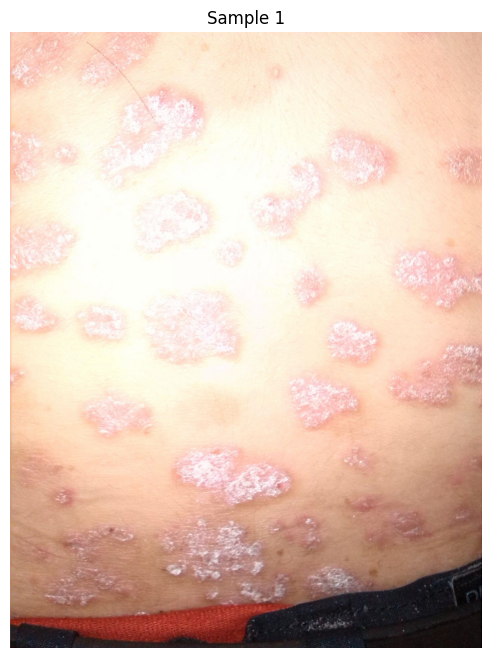


INPUT TO LLM:
--------------------------------------------------------------------------------
Question: Based on the image, How much of the body is affected?
Question Metadata: Type: Site, Category: General
Clinical Context: Pleural effusion accompanied by rash
A patient with pleural effusion is accompanied by a systemic rash, as seen in the picture (currently only the back picture is available).
Options: 1. single spot, 2. limited area, 3. widespread, 4. Not mentioned
--------------------------------------------------------------------------------

EXPECTED OUTPUT FROM LLM:
--------------------------------------------------------------------------------
['limited area']
--------------------------------------------------------------------------------

SYSTEM MESSAGE (contexts the interaction):
--------------------------------------------------------------------------------
You are a medical image analysis assistant. Your only task is to examine the provided clinical images and select

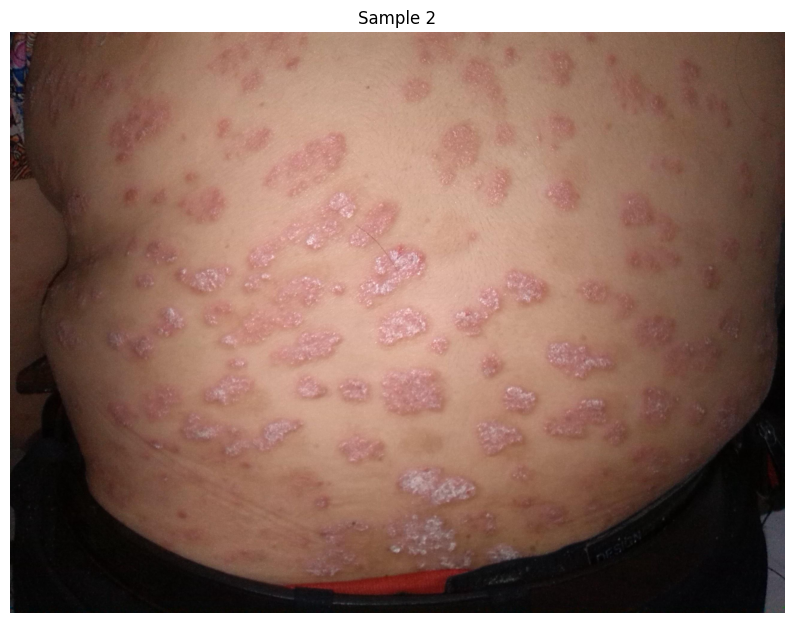


INPUT TO LLM:
--------------------------------------------------------------------------------
Question: Based on the image, How much of the body is affected?
Question Metadata: Type: Site, Category: General
Clinical Context: Pleural effusion accompanied by rash
A patient with pleural effusion is accompanied by a systemic rash, as seen in the picture (currently only the back picture is available).
Options: 1. single spot, 2. limited area, 3. widespread, 4. Not mentioned
--------------------------------------------------------------------------------

EXPECTED OUTPUT FROM LLM:
--------------------------------------------------------------------------------
['limited area']
--------------------------------------------------------------------------------

SYSTEM MESSAGE (contexts the interaction):
--------------------------------------------------------------------------------
You are a medical image analysis assistant. Your only task is to examine the provided clinical images and select

In [47]:
def inspect_llm_input(processed_data_dir, num_samples=3):
    """
    Load and display what the LLM receives during training, including
    the images, query text with clinical context, and expected answers.
    """
    # Load the first batch file
    batch_file = os.path.join(processed_data_dir, "batch_0.pkl")
    with open(batch_file, 'rb') as f:
        batch_data = pickle.load(f)
    
    # Print info about the number of samples
    print(f"Total samples in batch: {len(batch_data)}")
    
    # Display the requested number of samples
    for i, sample in enumerate(batch_data[:num_samples]):
        print(f"\n{'='*80}")
        print(f"SAMPLE {i+1} of {num_samples}")
        print(f"{'='*80}")
        
        # Print metadata
        print(f"ID: {sample['id']}")
        print(f"Question ID: {sample['qid']}")
        print(f"Type: {sample['question_type']}")
        print(f"Category: {sample['question_category']}")
        
        # Load and display the image
        img = Image.open(sample['image_path'])
        width, height = img.size
        print(f"Image dimensions: {width}x{height}, Format: {img.format}")
        
        # Display the image
        plt.figure(figsize=(10, 8))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Sample {i+1}")
        plt.show()
        
        # Display the inputs the LLM receives
        print("\nINPUT TO LLM:")
        print("-" * 80)
        print(sample['query_text'])
        print("-" * 80)
        
        # Display expected answer
        print("\nEXPECTED OUTPUT FROM LLM:")
        print("-" * 80)
        print(sample['answer_text'])
        print("-" * 80)
        
        # Display the system message that sets the context for the LLM
        print("\nSYSTEM MESSAGE (contexts the interaction):")
        print("-" * 80)
        print("You are a medical image analysis assistant. Your only task is to examine the provided clinical images and select the exact option text that best describes what you see. Note this is not the full context so if you are unsure or speculate other regions being affected, respond with 'Not mentioned'. You must respond with the full text of one of the provided options, exactly as written. Do not include any additional words or reasoning. Given the medical context, err on the side of caution when uncertain.")
        print("-" * 80)

# Run the function to show what the LLM gets
inspect_llm_input(processed_data_dir, num_samples=2)

In [48]:
class MedicalImageDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, processor):
        self.processor = processor
        self.examples = []
        
        for batch_file in sorted(os.listdir(data_dir)):
            if batch_file.startswith("batch_") and batch_file.endswith(".pkl"):
                with open(os.path.join(data_dir, batch_file), 'rb') as f:
                    batch_data = pickle.load(f)
                    self.examples.extend(batch_data)
    
    def __len__(self):
        return len(self.examples)
    
    def __getitem__(self, idx):
        example = self.examples[idx]
        
        # Open image and convert to RGB
        image = Image.open(example['image_path']).convert("RGB")
        
        # Define system message for medical image analysis
        system_message = """You are a medical image analysis assistant. Your task is to examine the provided clinical images along with clinical context, and select the option(s) that best describe what you see. 

        IMPORTANT: You must respond ONLY with the exact text of the option(s) that apply. 
        - Do not provide any explanations
        - Do not include option numbers
        - Do not write "Options:" or similar prefixes
        - Do not write "Answer:" or similar prefixes
        - Multiple answers should be separated by commas
        - If unsure, respond with "Not mentioned
        
        """
        
        # Format as a conversation with system, user, and assistant messages
        messages = [
            {
                "role": "system",
                "content": [{"type": "text", "text": system_message}],
            },
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": example['query_text']},
                    {"type": "image", "image": image},
                ],
            },
            {
                "role": "assistant",
                "content": [{"type": "text", "text": example['answer_text']}],
            },
        ]
        
        return {"messages": messages}

In [9]:
# Load Hugging Face token if needed
load_dotenv()
hf_token = os.getenv("HF_TOKEN")  # Make sure to set this in a .env file or environment

# Set model ID
model_id = "google/gemma-3-4b-it"  # We'll use Gemma 3 4B with image understanding capabilities

# Load processor first to use in the dataset class
processor = AutoProcessor.from_pretrained(model_id, token=hf_token)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [50]:
# Create helper functions
def create_dummy_image():
    """Create a small black image as a placeholder."""
    return Image.new('RGB', (224, 224), color='black')

def collate_fn(examples):
    """Custom collate function for batching examples."""
    texts = []
    images = []
    
    for example in examples:
        # Extract image from messages
        image_input = None
        for msg in example["messages"]:
            if msg["role"] == "user":
                for content in msg["content"]:
                    if isinstance(content, dict) and content.get("type") == "image" and "image" in content:
                        image_input = content["image"]
                        break
        
        if image_input is None:
            image_input = create_dummy_image()
            
        text = processor.apply_chat_template(
            example["messages"], add_generation_prompt=False, tokenize=False
        )
        
        texts.append(text.strip())
        images.append([image_input])
    
    batch = processor(
        text=texts, 
        images=images,
        return_tensors="pt", 
        padding=True
    )
    
    labels = batch["input_ids"].clone()
    
    # Get token IDs for special tokens to mask in loss computation
    boi_token_id = processor.tokenizer.convert_tokens_to_ids(
        processor.tokenizer.special_tokens_map["boi_token"]
    )
    eoi_token_id = processor.tokenizer.convert_tokens_to_ids(
        processor.tokenizer.special_tokens_map["eoi_token"]
    )
    
    # Mask tokens that shouldn't contribute to the loss
    labels[labels == processor.tokenizer.pad_token_id] = -100
    labels[labels == boi_token_id] = -100
    labels[labels == eoi_token_id] = -100
    
    batch["labels"] = labels
    return batch

In [51]:
# Create and test the dataset
dataset = MedicalImageDataset(processed_data_dir, processor)
print(f"Dataset size: {len(dataset)}")

if len(dataset) == 0:
    print("ERROR: Dataset is empty! Check data loading process.")
else:
    sample_size = min(3, len(dataset))
    print(f"Sampling {sample_size} examples from dataset")
    
    sample_examples = [dataset[i] for i in range(sample_size)]
    
    print(f"Sample size: {len(sample_examples)}")
    print("First example keys:", list(sample_examples[0].keys()))
    
    # Display the message structure for each sample
    for i in range(sample_size):
        example = dataset[i]
        print(f"\nExample {i+1} message structure:")
        print(f"System role: {example['messages'][0]}")
        print(f"User role content:")
        print(f"  Text: {example['messages'][1]['content'][0]['text'][:200]}...")  # Show first 200 chars
        print(f"  Image: {type(example['messages'][1]['content'][1]['image'])}")
        print(f"Assistant role: {example['messages'][2]}")
    
    # Test the collate function
    batch = collate_fn(sample_examples)
    print("\nCollated batch contains:", list(batch.keys()))
    print(f"Input_ids shape: {batch['input_ids'].shape}")
    print(f"Labels shape: {batch['labels'].shape}")

Dataset size: 7893
Sampling 3 examples from dataset
Sample size: 3
First example keys: ['messages']

Example 1 message structure:
System role: {'role': 'system', 'content': [{'type': 'text', 'text': 'You are a medical image analysis assistant. Your task is to examine the provided clinical images along with clinical context, and select the option(s) that best describe what you see. \n\n        IMPORTANT: You must respond ONLY with the exact text of the option(s) that apply. \n        - Do not provide any explanations\n        - Do not include option numbers\n        - Do not write "Options:" or similar prefixes\n        - Do not write "Answer:" or similar prefixes\n        - Multiple answers should be separated by commas\n        - If unsure, respond with "Not mentioned\n        \n        '}]}
User role content:
  Text: Question: Based on the image, How much of the body is affected?
Question Metadata: Type: Site, Category: General
Clinical Context: Pleural effusion accompanied by rash
A

In [ ]:
# Test with a simple dataloader
dataloader = DataLoader(
    dataset,
    batch_size=8,  # Adjust based on GPU memory
    shuffle=True,
    collate_fn=collate_fn
)

total_examples = 0
for batch in dataloader:
    # Process each batch. Note: in training, pass this to model.forward()
    batch_size = len(batch["input_ids"])
    total_examples += batch_size
    print(f"Processed batch with {batch_size} examples")

print(f"Processed all {total_examples} examples")

In [10]:
# Check if GPU can support bfloat16
if torch.cuda.is_available() and torch.cuda.get_device_capability()[0] < 8:
    print("WARNING: GPU may not fully support bfloat16. Consider using float16 instead.")

# Configure the model parameters
model_kwargs = dict(
    attn_implementation="eager",
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

# Configure quantization for memory efficiency
model_kwargs["quantization_config"] = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=model_kwargs["torch_dtype"],
    bnb_4bit_quant_storage=model_kwargs["torch_dtype"],
)

# Load the model
model = AutoModelForImageTextToText.from_pretrained(model_id, **model_kwargs, token=hf_token)

# Print info about the chat template
print(f"Default chat template: {processor.tokenizer.chat_template}")
print(f"Special tokens map: {processor.tokenizer.special_tokens_map}")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Default chat template: {{ bos_token }}
{%- if messages[0]['role'] == 'system' -%}
    {%- if messages[0]['content'] is string -%}
        {%- set first_user_prefix = messages[0]['content'] + '

' -%}
    {%- else -%}
        {%- set first_user_prefix = messages[0]['content'][0]['text'] + '

' -%}
    {%- endif -%}
    {%- set loop_messages = messages[1:] -%}
{%- else -%}
    {%- set first_user_prefix = "" -%}
    {%- set loop_messages = messages -%}
{%- endif -%}
{%- for message in loop_messages -%}
    {%- if (message['role'] == 'user') != (loop.index0 % 2 == 0) -%}
        {{ raise_exception("Conversation roles must alternate user/assistant/user/assistant/...") }}
    {%- endif -%}
    {%- if (message['role'] == 'assistant') -%}
        {%- set role = "model" -%}
    {%- else -%}
        {%- set role = message['role'] -%}
    {%- endif -%}
    {{ '<start_of_turn>' + role + '
' + (first_user_prefix if loop.first else "") }}
    {%- if message['content'] is string -%}
        {{ messag

In [ ]:
# Configure LoRA for efficient fine-tuning
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.05,
    r=16,
    bias="none",
    target_modules="all-linear",  # Apply LoRA to all linear layers
    task_type="CAUSAL_LM",
    modules_to_save=["lm_head", "embed_tokens"],  # Save these modules fully
)

In [ ]:
# Set up training configuration
output_dir = "outputs/finetuned-model"

training_args = SFTConfig(
    output_dir=output_dir,
    num_train_epochs=3,  # Adjust based on dataset size
    per_device_train_batch_size=1,  # Adjust based on GPU memory
    gradient_accumulation_steps=8,  # Accumulate gradients to simulate larger batch
    gradient_checkpointing=True,
    optim="adamw_torch_fused",
    logging_steps=10,
    save_strategy="epoch",
    learning_rate=2e-4,
    bf16=True,  # Use bfloat16 precision
    max_grad_norm=0.3,
    warmup_ratio=0.03,
    lr_scheduler_type="constant",
    push_to_hub=False,  # Set to True if you want to push to Hub
    report_to="tensorboard",
    gradient_checkpointing_kwargs={"use_reentrant": False},
    dataset_text_field="",
    dataset_kwargs={"skip_prepare_dataset": True},
    remove_unused_columns=False,  # Critical for custom datasets
    label_names=["labels"],  # Explicitly setting label_names
)

In [ ]:
# Initialize the trainer with all components
trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    peft_config=peft_config,
    processing_class=processor,
    data_collator=collate_fn,
)

# Start training
trainer.train()

In [ ]:
# # Commenting this out as my training didn't complete

# # Save the trained model
# trainer.save_model()
# print("Training complete and model saved!")

In [ ]:
# # Commenting this out as my training didn't complete

# # Clean up memory first
# del model
# del trainer
# torch.cuda.empty_cache()

In [10]:
# checkpoint_path = "outputs/finetuned-model/checkpoint-1974"

# # Load base model
# # model = AutoModelForImageTextToText.from_pretrained(model_id, low_cpu_mem_usage=True, token=hf_token)
# model = AutoModelForImageTextToText.from_pretrained(model_id, torch_dtype=torch.bfloat16, device_map="auto", low_cpu_mem_usage=True, token=hf_token)

# # Merge LoRA weights into base model
# # peft_model = PeftModel.from_pretrained(model, output_dir)
# peft_model = PeftModel.from_pretrained(model, checkpoint_path)
# merged_model = peft_model.merge_and_unload()

# # Save the merged model
# merged_dir = "outputs/merged_model"
# merged_model.save_pretrained(merged_dir, safe_serialization=True, max_shard_size="2GB")

# # Save the processor alongside the model
# # processor = AutoProcessor.from_pretrained(output_dir)
# processor = AutoProcessor.from_pretrained(checkpoint_path)
# processor.save_pretrained(merged_dir)

# print(f"Merged model saved to {merged_dir}")

# # Gives base model
# model = AutoModelForImageTextToText.from_pretrained(model_id, torch_dtype=torch.bfloat16, device_map="auto", low_cpu_mem_usage=True, token=hf_token)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [13]:
# # I think this was useless

# # After loading the model and processor
# print("Chat template: ", processor.tokenizer.chat_template)
# print("Special tokens: ", processor.tokenizer.special_tokens_map)

# # Check processor capabilities
# print("Processor components: ", processor.__dict__.keys())

In [14]:
# I think this was useless

# # Create a dummy function to process and see what happens
# def inspect_input_format():
#     # System message
#     system_message = """You are a medical image analysis assistant. Your task is to examine the provided clinical images along with clinical context, and select the option(s) that best describe what you see."""

#     # Two variants of user messages - with and without "Based on the image,"
#     user_message_with = "Question: Based on the image, How much of the body is affected?"
#     user_message_without = "Question: How much of the body is affected?"
    
#     # Create message formats
#     messages_with = [
#         {"role": "system", "content": [{"type": "text", "text": system_message}]},
#         {"role": "user", "content": [
#             {"type": "text", "text": user_message_with},
#             {"type": "image", "image": "IMAGE_PLACEHOLDER"}  # Just for formatting inspection
#         ]}
#     ]
    
#     messages_without = [
#         {"role": "system", "content": [{"type": "text", "text": system_message}]},
#         {"role": "user", "content": [
#             {"type": "text", "text": user_message_without},
#             {"type": "image", "image": "IMAGE_PLACEHOLDER"}  # Just for formatting inspection
#         ]}
#     ]
    
#     # Apply chat template to both
#     formatted_with = processor.apply_chat_template(messages_with, tokenize=False)
#     formatted_without = processor.apply_chat_template(messages_without, tokenize=False)
    
#     print("WITH 'Based on the image,':")
#     print(formatted_with)
#     print("\nWITHOUT 'Based on the image,':")
#     print(formatted_without)
    
#     # Look at the token lengths (might reveal alignment issues)
#     tokens_with = processor.tokenizer(formatted_with)
#     tokens_without = processor.tokenizer(formatted_without)
    
#     print(f"\nToken count WITH: {len(tokens_with['input_ids'])}")
#     print(f"Token count WITHOUT: {len(tokens_without['input_ids'])}")

# # Run the inspection
# inspect_input_format()

In [15]:
# Function to load and prepare validation data
def prepare_validation_data():
    """
    Create a validation dataframe similar to the training dataframe.
    """
    print("Preparing validation data...")
    
    # Load question definitions
    questions_path = os.path.join(TRAIN_DIR, "closedquestions_definitions_imageclef2025.json")
    with open(questions_path, 'r') as f:
        questions = json.load(f)
        
    # Convert to DataFrame for easier manipulation
    questions_df = pd.json_normalize(questions)[["qid", "question_en", "options_en", "question_type_en", "question_category_en"]]
    
    # Load validation data with query information
    val_json_path = os.path.join(VAL_DIR, "valid.json")
    val_df = pd.read_json(val_json_path)
    
    # Extract relevant columns including query content and title
    query_info_df = val_df[["encounter_id", "image_ids", "query_title_en", "query_content_en", "author_id"]]
    
    # Load CVQA data (ground truth answers)
    cvqa_path = os.path.join(VAL_DIR, "valid_cvqa.json")
    with open(cvqa_path, 'r') as f:
        cvqa_data = json.load(f)
    cvqa_df = pd.json_normalize(cvqa_data)
    
    # Melt to get one row per question
    cvqa_long = cvqa_df.melt(id_vars=["encounter_id"], 
                             var_name="qid", 
                             value_name="answer_index")
    
    # Filter out encounter_id rows
    cvqa_long = cvqa_long[cvqa_long["qid"] != "encounter_id"]
    
    # Merge CVQA with questions
    cvqa_merged = cvqa_long.merge(questions_df, on="qid", how="left")
    
    # Get answer text
    def get_answer_text(row):
        try:
            return row["options_en"][row["answer_index"]]
        except (IndexError, TypeError):
            return None
    
    cvqa_merged["answer_text"] = cvqa_merged.apply(get_answer_text, axis=1)
    
    # Merge with validation data
    final_df = cvqa_merged.merge(query_info_df, on="encounter_id", how="left")
    
    # Extract the base CQID code
    final_df['base_qid'] = final_df['qid'].str.extract(r'(CQID\d+)')
    
    # Group by encounter_id and base_qid to see all answers for each question family
    grouped_by_family = final_df.groupby(['encounter_id', 'base_qid']).agg({
        'qid': list,
        'question_en': list,
        'answer_text': list,
        'answer_index': list,
        'image_ids': 'first',
        'options_en': 'first',
        'question_type_en': 'first',
        'question_category_en': 'first',
        'query_title_en': 'first',
        'query_content_en': 'first',
        'author_id': 'first'
    })
    
    # Reset index for easier manipulation
    grouped_by_family = grouped_by_family.reset_index()
    
    # Modified function to extract all valid answers (treating "Not mentioned" appropriately)
    def get_valid_answers(row):
        """
        Extract all valid answers, with special handling for "Not mentioned".
        If "Not mentioned" is the only answer for all slots, we keep it.
        Otherwise, we collect all non-"Not mentioned" answers.
        """
        answers = row['answer_text']
        answer_indices = row['answer_index']
        
        if all(ans == "Not mentioned" for ans in answers):
            return ["Not mentioned"], [answer_indices[0]]  # If all are "Not mentioned", return it as valid
        
        valid_answers = []
        valid_indices = []
        
        for i, ans in enumerate(answers):
            if ans != "Not mentioned" and ans not in valid_answers:
                valid_answers.append(ans)
                valid_indices.append(answer_indices[i])
        
        return valid_answers, valid_indices
    
    # Apply to all question families
    grouped_by_family[['valid_answers', 'valid_indices']] = grouped_by_family.apply(
        lambda row: pd.Series(get_valid_answers(row)), axis=1)
    
    # Create the multi-label validation dataset
    multi_label_data = []
    
    # Process all validation encounters
    for _, row in tqdm(grouped_by_family.iterrows(), desc="Creating validation dataset"):
        encounter_id = row['encounter_id']
        base_qid = row['base_qid']
        valid_answers = row['valid_answers']
        valid_indices = row['valid_indices']
        image_ids = row['image_ids']
        question_text = row['question_en'][0]  # Taking the first question as reference
        query_title = row['query_title_en']
        query_content = row['query_content_en']
        author_id = row['author_id']
        options_en = row['options_en']
        question_type_en = row['question_type_en']
        question_category_en = row['question_category_en']
        
        # For each image in the encounter
        for img_id in image_ids:
            img_path = os.path.join(VAL_IMAGES_DIR, img_id)
            
            # Skip if image doesn't exist
            if not os.path.exists(img_path):
                print(f"Warning: Image {img_id} not found at {img_path}")
                continue
                
            multi_label_data.append({
                'encounter_id': encounter_id,
                'base_qid': base_qid,
                'image_id': img_id,
                'image_path': img_path,
                'valid_answers': valid_answers,
                'valid_indices': valid_indices,
                'question_text': question_text,
                'query_title_en': query_title,
                'query_content_en': query_content,
                'author_id': author_id,
                'options_en': options_en,
                'question_type_en': question_type_en, 
                'question_category_en': question_category_en,
                'is_multi_label': len(valid_answers) > 1
            })
    
    # Convert to DataFrame
    val_dataset = pd.DataFrame(multi_label_data)
    
    # Save the dataset
    val_dataset.to_csv(os.path.join(OUTPUT_DIR, "val_dataset.csv"), index=False)
    
    print(f"Validation dataset created with {len(val_dataset)} entries")
    
    return val_dataset

# Function to process a batch for inference
def process_inference_batch(batch_df, batch_idx, save_dir, images_dir):
    """
    Process a batch of data samples for inference and save them as a pickle file.
    """
    os.makedirs(save_dir, exist_ok=True)
    batch_data = []
    
    for idx, row in tqdm(batch_df.iterrows(), total=len(batch_df), desc=f"Batch {batch_idx}"):
        try:
            # Get image path
            image_id = row.get('image_id')
            if not image_id:
                continue
                
            # Use the full image path if it's already in the dataframe
            if 'image_path' in row and os.path.exists(row['image_path']):
                image_path = row['image_path']
            else:
                # Otherwise construct from images_dir and image_id
                image_path = os.path.join(images_dir, image_id)
            
            if not os.path.exists(image_path):
                print(f"Image not found: {image_path}")
                continue

            # Verify the image is valid
            try:
                with Image.open(image_path) as img:
                    img.load()
            except Exception as e:
                print(f"Corrupt or unreadable image at {image_path} — {e}")
                continue
            
            # Get options from options_en
            if 'options_en' in row:
                options = safe_convert_options(row['options_en'])
#                 options = row['options_en']
#                 if isinstance(options, str):
#                     try:
#                         options = eval(options)
#                     except:
#                         options = options.split(',')
            else:
                options = ["Yes", "No", "Not mentioned"]
                
            options_text = ", ".join([f"{i+1}. {opt}" for i, opt in enumerate(options)])
            
            # Create metadata string
            metadata = ""
            if 'question_type_en' in row:
                metadata += f"Type: {row['question_type_en']}"
                
            if 'question_category_en' in row:
                metadata += f", Category: {row['question_category_en']}"
            
            # Get question text
            question = row.get('question_text', 'What do you see in this image?')
            
            # Get clinical context from query title and content
            query_title = row.get('query_title_en', '')
            query_content = row.get('query_content_en', '')
            
            # Create the clinical context section
            clinical_context = ""
            if query_title:
                clinical_context += f"Clinical Context: {query_title}\n"
            if query_content:
                clinical_context += f"{query_content}\n"
            
            # Create the full query text with clinical context
            query_text = (f"Question: {question}\n"
                         f"Question Metadata: {metadata}\n"
                         f"{clinical_context}"
                         f"Options: {options_text}")
            
            batch_data.append({
                "id": row.get('encounter_id', str(idx)),
                "qid": row.get('base_qid', ''),
                "query_text": query_text,
                "image_path": image_path,
                "question_type": row.get('question_type_en', ''),
                "question_category": row.get('question_category_en', '')
            })
        
        except Exception as e:
            print(f"Error processing row {idx}: {e}")
            import traceback
            traceback.print_exc()
    
    batch_file = os.path.join(save_dir, f"val_batch_{batch_idx}.pkl")
    with open(batch_file, 'wb') as f:
        pickle.dump(batch_data, f)
    
    return len(batch_data)

def preprocess_validation_dataset(df, batch_size=50, save_dir="outputs/processed_val_data", images_dir=None):
    """
    Process the entire validation dataset in batches
    """
    total_processed = 0
    
    # Use VAL_IMAGES_DIR global variable if images_dir is not provided
    if images_dir is None:
        images_dir = VAL_IMAGES_DIR
    
    for i in range(0, len(df), batch_size):
        batch_df = df.iloc[i:i+batch_size]
        batch_idx = i // batch_size
        
        print(f"Processing batch {batch_idx+1}/{(len(df)-1)//batch_size + 1}")
        processed = process_inference_batch(batch_df, batch_idx, save_dir, images_dir)
        total_processed += processed
        
        gc.collect()
        
        print(f"Processed {total_processed} examples so far")
    
    return total_processed

In [16]:
# Class for inference
class MedicalImageInference:
    def __init__(self, model_path, device="cuda" if torch.cuda.is_available() else "cpu"):
        self.device = device
        self.processor = AutoProcessor.from_pretrained(model_path)
        
        # Configure model parameters
        model_kwargs = dict(
            attn_implementation="eager",
            torch_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32,
            device_map="auto" if torch.cuda.is_available() else None
        )
        
        # Configure quantization for memory efficiency
        model_kwargs["quantization_config"] = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=model_kwargs["torch_dtype"],
            bnb_4bit_quant_storage=model_kwargs["torch_dtype"]
        )
        
        # Load the model with the same configuration
        self.model = AutoModelForImageTextToText.from_pretrained(
            model_path, 
            **model_kwargs
        )
        self.model.eval()
        
    def predict(self, query_text, image_path, max_new_tokens=100):
        try:
            # Load the image
            image = Image.open(image_path).convert("RGB")

            # Create the system message
#             system_message = "You are a medical image analysis assistant. Your task is to examine the provided clinical images along with any provided clinical context, and select the option(s) that best describe what you see. Multiple answers may be correct for some questions. Respond with the exact text of the option(s) that apply. Given the medical context, err on the side of caution when uncertain."

            system_message = """You are a medical image analysis assistant. Your task is to examine the provided clinical images along with clinical context, and select the option(s) that best describe what you see. 

            IMPORTANT: You must respond ONLY with the exact text of the option(s) that apply. 
            - Do not provide any explanations
            - Do not include option numbers
            - Do not write "Options:" or similar prefixes
            - Do not write "Answer:" or similar prefixes
            - Multiple answers should be separated by commas
            - If unsure, respond with "Not mentioned

            """
            
            # Format as a conversation with system and user messages
            messages = [
                {
                    "role": "system",
                    "content": [{"type": "text", "text": system_message}],
                },
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": query_text},
                        {"type": "image", "image": image},
                    ],
                }
            ]

            # Create model inputs
            inputs = self.processor(
                text=self.processor.apply_chat_template(messages, tokenize=False),
                images=image,
                return_tensors="pt"
            ).to(self.device)

            # Generate prediction
            with torch.no_grad():
                generated_ids = self.model.generate(
                    **inputs,
                    max_new_tokens=max_new_tokens,
                    do_sample=False
                )

            # Get only the new tokens (the model's answer)
            input_length = inputs.input_ids.shape[1]
            new_tokens = generated_ids[0][input_length:]

            # Decode only the new tokens
            prediction = self.processor.decode(new_tokens, skip_special_tokens=True)

            # Clean the prediction - remove any remaining template artifacts
            prediction = prediction.strip()
            if prediction.startswith("model\n"):
                prediction = prediction[len("model\n"):]
            
            # Extract just the answer text
            if "Answer:" in prediction:
                parts = prediction.split("Answer:")
                if len(parts) > 1:
                    prediction = parts[1].strip()
                
            if prediction.startswith("<start_of_turn>model") or prediction.startswith("<start_of_turn>assistant"):
                prediction = prediction.split("\n", 1)[1] if "\n" in prediction else ""
            if prediction.endswith("<end_of_turn>"):
                prediction = prediction[:-len("<end_of_turn>")]

            return prediction.strip()
        except Exception as e:
            print(f"Error during prediction for {image_path}: {e}")
            import traceback
            traceback.print_exc()
            return "Not mentioned"  # Default to not mentioned in case of errors
    
    def batch_predict(self, processed_data_dir, output_file, max_samples=None):
        """
        Run inference on a batch of preprocessed data
        """
        results = []
        sample_count = 0
        
        # Load all batch files
        batch_files = sorted([f for f in os.listdir(processed_data_dir) if f.startswith("val_batch_") and f.endswith(".pkl")])
        
        # Process each batch file
        for batch_file in tqdm(batch_files, desc="Processing batches"):
            with open(os.path.join(processed_data_dir, batch_file), 'rb') as f:
                batch_data = pickle.load(f)
            
            # Process each sample in the batch
            for sample in tqdm(batch_data, desc=f"Predicting {batch_file}", leave=False):
                # Get prediction
                prediction = self.predict(sample["query_text"], sample["image_path"])
                
                # Save results
                results.append({
                    "encounter_id": sample["id"],
                    "base_qid": sample["qid"],
                    "image_id": os.path.basename(sample["image_path"]),
                    "prediction": prediction
                })
                
                sample_count += 1
                if max_samples and sample_count >= max_samples:
                    break
                
            if max_samples and sample_count >= max_samples:
                break
        
        # Convert to DataFrame and save
        results_df = pd.DataFrame(results)
        results_df.to_csv(output_file, index=False)
        
        return results_df

    # Update the aggregate_predictions method in the MedicalImageInference class
    def aggregate_predictions(self, predictions_df, validation_df=None):
        """
        Aggregate predictions for each encounter and question ID
        For each encounter-question pair, collect unique predictions across all images,
        respecting the maximum allowed answers for each question type.

        Parameters:
        - predictions_df: DataFrame with prediction results
        - validation_df: Optional DataFrame containing validation data with options_en
        """
        # Define maximum allowed answers for each question type
        max_answers = {
            'CQID010': 1,  # Single answer
            'CQID011': 6,  # Up to 6 answers
            'CQID012': 6,  # Up to 6 answers
            'CQID015': 1,  # Single answer
            'CQID020': 9,  # Up to 9 answers
            'CQID025': 1,  # Single answer
            'CQID034': 1,  # Single answer
            'CQID035': 1,  # Single answer
            'CQID036': 1   # Single answer
        }

        # Set default max_answers for any question type not explicitly listed
        default_max_answers = 1

        # Group by encounter_id and base_qid
        grouped = predictions_df.groupby(['encounter_id', 'base_qid'])

        aggregated_results = []

        for (encounter_id, base_qid), group in tqdm(grouped, desc="Aggregating predictions"):
            # Extract all predictions for this group
            predictions = group['prediction'].tolist()
            image_ids = group['image_id'].tolist()

            # Process predictions to standardize format
            cleaned_predictions = []
            for pred in predictions:
                # Handle predictions that might be in a list format
                if isinstance(pred, str):
                    if pred.startswith('[') and pred.endswith(']'):
                        try:
                            # Try to evaluate as a Python list
                            pred_list = safe_convert_options(pred)
    #                         pred_list = eval(pred)
                            if isinstance(pred_list, list):
                                cleaned_predictions.extend(pred_list)
                                continue
                        except:
                            pass

                # Handle comma-separated values
                if isinstance(pred, str) and ',' in pred:
#                 if ',' in pred:
                    cleaned_predictions.extend([p.strip() for p in pred.split(',')])
                else:
                    cleaned_predictions.append(str(pred).strip())
#                     cleaned_predictions.append(pred.strip())

            all_cleaned_predictions = cleaned_predictions.copy()

            # Count frequencies of each prediction
            from collections import Counter
            prediction_counts = Counter(cleaned_predictions)

            # Get question type for determining max allowed answers
            question_type = base_qid.split('-')[0] if '-' in base_qid else base_qid

            # Determine max allowed answers for this question type
            allowed_max = max_answers.get(question_type, default_max_answers)

            # Sort predictions by frequency (most common first)
            sorted_predictions = sorted(prediction_counts.items(), 
                                       key=lambda x: x[1], 
                                       reverse=True)

            all_sorted_predictions = sorted_predictions.copy()
            
            # Get top N predictions where N is the max allowed
            top_predictions = [p[0] for p in sorted_predictions[:allowed_max]]

            # If there are ties at the cutoff point, randomly select to meet the max limit
            if len(sorted_predictions) > allowed_max:
                # Check if there's a tie at the cutoff
                cutoff_count = sorted_predictions[allowed_max-1][1]
                tied_predictions = [p[0] for p in sorted_predictions if p[1] == cutoff_count]

                # If we have more tied predictions than slots available
                if len(tied_predictions) > 1 and len(top_predictions) > allowed_max - len(tied_predictions):
                    # Remove all tied predictions from top_predictions
                    top_predictions = [p for p in top_predictions if p not in tied_predictions]

                    # Randomly select from tied predictions to fill remaining slots
                    import random
                    random.seed(42)  # For reproducibility
                    slots_remaining = allowed_max - len(top_predictions)
                    selected_tied = random.sample(tied_predictions, slots_remaining)

                    # Add the randomly selected tied predictions
                    top_predictions.extend(selected_tied)

            # If "Not mentioned" is in predictions but there are other predictions,
            # remove "Not mentioned" (unless it's the only prediction)
            if len(top_predictions) > 1 and "Not mentioned" in top_predictions:
                top_predictions.remove("Not mentioned")

            # Create a single, combined prediction
            combined_prediction = ", ".join(top_predictions)

            # Initialize options_en as None
            options_en = None

            # If validation_df is provided, try to get options_en from it
            if validation_df is not None:
                # Find matching rows in validation_df
                matching_rows = validation_df[(validation_df['encounter_id'] == encounter_id) & 
                                             (validation_df['base_qid'] == base_qid)]
                if not matching_rows.empty:
                    # Get options_en from the first matching row
                    options_en = matching_rows.iloc[0].get('options_en')

            result_dict = {
                "encounter_id": encounter_id,
                "base_qid": base_qid,
                "image_ids": image_ids,
                "unique_predictions": top_predictions,  # Now limited to max allowed
                "combined_prediction": combined_prediction,
                "all_raw_predictions": all_cleaned_predictions,
                "all_sorted_predictions": all_sorted_predictions
            }

            # Add options_en only if it's available
            if options_en is not None:
                result_dict["options_en"] = options_en

            aggregated_results.append(result_dict)

        # Convert to DataFrame
        aggregated_df = pd.DataFrame(aggregated_results)

        return aggregated_df

In [17]:
# Create a simple class to simulate command-line arguments
class Args:
    def __init__(self):
#         self.test = True  # Set to True to run in test mode
#         self.skip_data_prep = False  # Set to True to skip data preparation
#         self.batch_size = 100
#         self.max_samples = 50  # Limit number of samples for inference
#         self.model_path = "outputs/merged_model"
        self.test = False  # Set to False to run on full dataset
        self.skip_data_prep = False  # Set to False to process all data
        self.batch_size = 100
        self.max_samples = None  # No limit on samples
#         self.model_path = "outputs/merged_model"
        self.model_path = model_id
        
args = Args()
processed_val_dir = "outputs/processed_val_data"
os.makedirs(processed_val_dir, exist_ok=True)

if not args.skip_data_prep:
    # Prepare data for validation
    print("Preparing validation dataset...")
    val_df = prepare_validation_data()
    
    # Subset for testing if requested
    if args.test:
        print("Running in test mode with a small subset of data...")
        test_size = min(500, len(val_df))
        val_df = val_df.head(test_size)
    
    # Process validation data
    # Clear any existing processed data
    import shutil
    if os.path.exists(processed_val_dir):
        shutil.rmtree(processed_val_dir)
        os.makedirs(processed_val_dir)
    
    total_examples = preprocess_validation_dataset(val_df, batch_size=args.batch_size, save_dir=processed_val_dir)
    print(f"Total processed validation examples: {total_examples}")
else:
    print("Skipping data preparation...")

Preparing validation dataset...
Preparing validation data...


Creating validation dataset: 0it [00:00, ?it/s]

Validation dataset created with 1413 entries
Processing batch 1/15


Batch 0:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 100 examples so far
Processing batch 2/15


Batch 1:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 200 examples so far
Processing batch 3/15


Batch 2:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 300 examples so far
Processing batch 4/15


Batch 3:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 400 examples so far
Processing batch 5/15


Batch 4:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 500 examples so far
Processing batch 6/15


Batch 5:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 600 examples so far
Processing batch 7/15


Batch 6:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 700 examples so far
Processing batch 8/15


Batch 7:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 800 examples so far
Processing batch 9/15


Batch 8:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 900 examples so far
Processing batch 10/15


Batch 9:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 1000 examples so far
Processing batch 11/15


Batch 10:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 1100 examples so far
Processing batch 12/15


Batch 11:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 1200 examples so far
Processing batch 13/15


Batch 12:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 1300 examples so far
Processing batch 14/15


Batch 13:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 1400 examples so far
Processing batch 15/15


Batch 14:   0%|          | 0/13 [00:00<?, ?it/s]

Processed 1413 examples so far
Total processed validation examples: 1413


In [18]:
val_df.head()

,encounter_id,base_qid,image_id,image_path,valid_answers,valid_indices,question_text,query_title_en,query_content_en,author_id,options_en,question_type_en,question_category_en,is_multi_label
0,ENC00852,CQID010,IMG_ENC00852_00001.jpg,/storage/coda1/p-dsgt_clef2025/0/kthakrar3/med...,[limited area],[1],How much of the body is affected?,Is this Vitiligo? Please see picture.,"The patient is a middle age female, about 50 y...",U00295,"[single spot, limited area, widespread, Not me...",Site,General,False
1,ENC00852,CQID010,IMG_ENC00852_00002.jpg,/storage/coda1/p-dsgt_clef2025/0/kthakrar3/med...,[limited area],[1],How much of the body is affected?,Is this Vitiligo? Please see picture.,"The patient is a middle age female, about 50 y...",U00295,"[single spot, limited area, widespread, Not me...",Site,General,False
2,ENC00852,CQID011,IMG_ENC00852_00001.jpg,/storage/coda1/p-dsgt_clef2025/0/kthakrar3/med...,"[upper extremities, head]","[2, 0]",1 Where is the affected area?,Is this Vitiligo? Please see picture.,"The patient is a middle age female, about 50 y...",U00295,"[head, neck, upper extremities, lower extremit...",Site Location,General,True
3,ENC00852,CQID011,IMG_ENC00852_00002.jpg,/storage/coda1/p-dsgt_clef2025/0/kthakrar3/med...,"[upper extremities, head]","[2, 0]",1 Where is the affected area?,Is this Vitiligo? Please see picture.,"The patient is a middle age female, about 50 y...",U00295,"[head, neck, upper extremities, lower extremit...",Site Location,General,True
4,ENC00852,CQID012,IMG_ENC00852_00001.jpg,/storage/coda1/p-dsgt_clef2025/0/kthakrar3/med...,[size of palm],[1],1 How large are the affected areas? Please spe...,Is this Vitiligo? Please see picture.,"The patient is a middle age female, about 50 y...",U00295,"[size of thumb nail, size of palm, larger area...",Size,General,False


In [19]:
not_mentioned_rows = val_df[val_df['valid_answers'].apply(lambda x: 'Not mentioned' in x)]
not_mentioned_rows.head(5) # works appropriately

,encounter_id,base_qid,image_id,image_path,valid_answers,valid_indices,question_text,query_title_en,query_content_en,author_id,options_en,question_type_en,question_category_en,is_multi_label
6,ENC00852,CQID015,IMG_ENC00852_00001.jpg,/storage/coda1/p-dsgt_clef2025/0/kthakrar3/med...,[Not mentioned],[6],When did the patient first notice the issue?,Is this Vitiligo? Please see picture.,"The patient is a middle age female, about 50 y...",U00295,"[within hours, within days, within weeks, with...",Onset,General,False
7,ENC00852,CQID015,IMG_ENC00852_00002.jpg,/storage/coda1/p-dsgt_clef2025/0/kthakrar3/med...,[Not mentioned],[6],When did the patient first notice the issue?,Is this Vitiligo? Please see picture.,"The patient is a middle age female, about 50 y...",U00295,"[within hours, within days, within weeks, with...",Onset,General,False
16,ENC00852,CQID036,IMG_ENC00852_00001.jpg,/storage/coda1/p-dsgt_clef2025/0/kthakrar3/med...,[Not mentioned],[2],What is the skin lesion texture?,Is this Vitiligo? Please see picture.,"The patient is a middle age female, about 50 y...",U00295,"[smooth, rough, Not mentioned]",Texture,Skin Specific,False
17,ENC00852,CQID036,IMG_ENC00852_00002.jpg,/storage/coda1/p-dsgt_clef2025/0/kthakrar3/med...,[Not mentioned],[2],What is the skin lesion texture?,Is this Vitiligo? Please see picture.,"The patient is a middle age female, about 50 y...",U00295,"[smooth, rough, Not mentioned]",Texture,Skin Specific,False
73,ENC00855,CQID025,IMG_ENC00855_00001.jpg,/storage/coda1/p-dsgt_clef2025/0/kthakrar3/med...,[Not mentioned],[2],Is there any associated itching with the skin ...,Sharing a disease commonly seen,"Patient: male, 32 years old. Got the disease ...",U00904,"[yes, no, Not mentioned]",Itch,Skin Specific,False


In [20]:
# What is inference using

def inspect_inference_inputs(processed_val_dir, num_samples=3):
    """
    Inspect the actual inputs being used during inference by examining the
    processed validation data files.
    
    Args:
        processed_val_dir: Directory containing processed validation data
        num_samples: Number of samples to display
    """
    # Find all batch files
    batch_files = sorted([f for f in os.listdir(processed_val_dir) 
                         if f.startswith("val_batch_") and f.endswith(".pkl")])
    
    if not batch_files:
        print(f"No batch files found in {processed_val_dir}")
        return
    
    print(f"Found {len(batch_files)} batch files in {processed_val_dir}")
    
    # Load the first batch file
    with open(os.path.join(processed_val_dir, batch_files[0]), 'rb') as f:
        batch_data = pickle.load(f)
    
    print(f"Batch contains {len(batch_data)} samples")
    
    # Display the requested number of samples
    for i, sample in enumerate(batch_data[:num_samples]):
        print(f"\n{'='*80}")
        print(f"SAMPLE {i+1}")
        print(f"{'='*80}")
        
        # Display metadata
        print(f"ID: {sample['id']}")
        print(f"Question ID: {sample['qid']}")
        
        # Display the data that would be fed to the model
        print("\nSYSTEM MESSAGE (Used during inference):")
        print("-" * 80)
        system_message = """You are a medical image analysis assistant. Your task is to examine the provided clinical images along with clinical context, and select the option(s) that best describe what you see. 

IMPORTANT: You must respond ONLY with the exact text of the option(s) that apply. 
- Do not provide any explanations
- Do not include option numbers
- Do not write "Options:" or similar prefixes
- Do not write "Answer:" or similar prefixes
- Multiple answers should be separated by commas
- If unsure, respond with "Not mentioned"
"""
        print(system_message)
        print("-" * 80)
        
        # Display the query text
        print("\nUSER MESSAGE TEXT (Used during inference):")
        print("-" * 80)
        print(sample['query_text'])
        print("-" * 80)
        
        # Display image information
        print("\nIMAGE (Used during inference):")
        print(f"Image path: {sample['image_path']}")
        
        # Try to display image dimensions if PIL is available
        try:
            from PIL import Image
            img = Image.open(sample['image_path'])
            print(f"Image dimensions: {img.size[0]}x{img.size[1]}, Format: {img.format}")
        except Exception as e:
            print(f"Could not open image: {e}")
        
        # Display fields NOT used during inference
        print("\nFIELDS NOT DIRECTLY USED DURING INFERENCE:")
        print("-" * 80)
        for key, value in sample.items():
            if key not in ['query_text', 'image_path', 'id']:
                print(f"{key}: {value}")
        print("-" * 80)
        
        # Option to stop after showing samples
        if i >= num_samples - 1:
            break

# Run the inspection function
inspect_inference_inputs(processed_val_dir, num_samples=2)

Found 15 batch files in outputs/processed_val_data
Batch contains 100 samples

SAMPLE 1
ID: ENC00852
Question ID: CQID010

SYSTEM MESSAGE (Used during inference):
--------------------------------------------------------------------------------
You are a medical image analysis assistant. Your task is to examine the provided clinical images along with clinical context, and select the option(s) that best describe what you see. 

IMPORTANT: You must respond ONLY with the exact text of the option(s) that apply. 
- Do not provide any explanations
- Do not include option numbers
- Do not write "Options:" or similar prefixes
- Do not write "Answer:" or similar prefixes
- Multiple answers should be separated by commas
- If unsure, respond with "Not mentioned"

--------------------------------------------------------------------------------

USER MESSAGE TEXT (Used during inference):
--------------------------------------------------------------------------------
Question: How much of the body i

In [21]:
# Load model and run inference
print(f"Loading model from {args.model_path}...")
inference = MedicalImageInference(args.model_path)

# Run inference on processed data
predictions_file = os.path.join(OUTPUT_DIR, 
                               f"val_predictions{'_test' if args.test else ''}.csv")
print(f"Running inference (max_samples={args.max_samples if args.max_samples else 'all'})...")
predictions_df = inference.batch_predict(processed_val_dir, predictions_file, max_samples=args.max_samples)

Loading model from google/gemma-3-4b-it...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Running inference (max_samples=all)...


Processing batches:   0%|          | 0/15 [00:00<?, ?it/s]

Predicting val_batch_0.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

/storage/coda1/p-dsgt_clef2025/0/kthakrar3/mediqa-magic-v2/.venv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:634: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/storage/coda1/p-dsgt_clef2025/0/kthakrar3/mediqa-magic-v2/.venv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:651: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `64` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


Predicting val_batch_1.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Predicting val_batch_10.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Predicting val_batch_11.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Predicting val_batch_12.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Predicting val_batch_13.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Predicting val_batch_14.pkl:   0%|          | 0/13 [00:00<?, ?it/s]

Predicting val_batch_2.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Predicting val_batch_3.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Predicting val_batch_4.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Predicting val_batch_5.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Predicting val_batch_6.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Predicting val_batch_7.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Predicting val_batch_8.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Predicting val_batch_9.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

In [22]:
# Aggregate predictions
print("Aggregating predictions...")

# Load the validation dataset
val_dataset = pd.read_csv(os.path.join(OUTPUT_DIR, "val_dataset.csv"))

# Run the inference

# Aggregate predictions with options_en
aggregated_df = inference.aggregate_predictions(predictions_df, validation_df=val_dataset)

# Save aggregated results
aggregated_file = os.path.join(OUTPUT_DIR, 
                              f"aggregated_predictions{'_test' if args.test else ''}.csv")
aggregated_df.to_csv(aggregated_file, index=False)

print(f"Inference complete. Results saved to {predictions_file} and {aggregated_file}")

Aggregating predictions...


Aggregating predictions:   0%|          | 0/504 [00:00<?, ?it/s]

Inference complete. Results saved to /storage/coda1/p-dsgt_clef2025/0/kthakrar3/mediqa-magic-v2/outputs/val_predictions.csv and /storage/coda1/p-dsgt_clef2025/0/kthakrar3/mediqa-magic-v2/outputs/aggregated_predictions.csv


In [23]:
# Print sample of predictions for inspection
print("\nSample of raw predictions:")
predictions_df.head(3)


Sample of raw predictions:


,encounter_id,base_qid,image_id,prediction
0,ENC00852,CQID010,IMG_ENC00852_00001.jpg,"limited area, single spot"
1,ENC00852,CQID010,IMG_ENC00852_00002.jpg,"limited area, single spot"
2,ENC00852,CQID011,IMG_ENC00852_00001.jpg,"upper extremities, back"


In [24]:
print("\nSample of aggregated predictions:")
aggregated_df.head(3)


Sample of aggregated predictions:


,encounter_id,base_qid,image_ids,unique_predictions,combined_prediction,all_raw_predictions,all_sorted_predictions,options_en
0,ENC00852,CQID010,"[IMG_ENC00852_00001.jpg, IMG_ENC00852_00002.jpg]",[limited area],limited area,"[limited area, single spot, limited area, sing...","[(limited area, 2), (single spot, 2)]","['single spot', 'limited area', 'widespread', ..."
1,ENC00852,CQID011,"[IMG_ENC00852_00001.jpg, IMG_ENC00852_00002.jpg]","[upper extremities, back]","upper extremities, back","[upper extremities, back, upper extremities]","[(upper extremities, 2), (back, 1)]","['head', 'neck', 'upper extremities', 'lower e..."
2,ENC00852,CQID012,"[IMG_ENC00852_00001.jpg, IMG_ENC00852_00002.jpg]",[larger area],larger area,"[larger area, larger area]","[(larger area, 2)]","['size of thumb nail', 'size of palm', 'larger..."


In [25]:
# # Load raw predictions
# # predictions = pd.read_csv("/storage/coda1/p-dsgt_clef2025/0/kthakrar3/mediqa-magic-v2/outputs/val_predictions_test.csv")
# predictions = pd.read_csv("/storage/coda1/p-dsgt_clef2025/0/kthakrar3/mediqa-magic-v2/outputs/val_predictions.csv")

# # Load aggregated predictions
# # aggregated = pd.read_csv("/storage/coda1/p-dsgt_clef2025/0/kthakrar3/mediqa-magic-v2/outputs/aggregated_predictions_test.csv")
# aggregated = pd.read_csv("/storage/coda1/p-dsgt_clef2025/0/kthakrar3/mediqa-magic-v2/outputs/aggregated_predictions.csv")

# Load raw predictions
predictions = pd.read_csv(f"/storage/coda1/p-dsgt_clef2025/0/kthakrar3/mediqa-magic-v2/outputs/val_predictions{'_test' if args.test else ''}.csv")

# Load aggregated predictions
aggregated = pd.read_csv(f"/storage/coda1/p-dsgt_clef2025/0/kthakrar3/mediqa-magic-v2/outputs/aggregated_predictions{'_test' if args.test else ''}.csv")

In [26]:
# Display sample predictions
print("Sample of individual predictions:")
predictions.head(5)[["encounter_id", "base_qid", "image_id", "prediction"]]

Sample of individual predictions:


,encounter_id,base_qid,image_id,prediction
0,ENC00852,CQID010,IMG_ENC00852_00001.jpg,"limited area, single spot"
1,ENC00852,CQID010,IMG_ENC00852_00002.jpg,"limited area, single spot"
2,ENC00852,CQID011,IMG_ENC00852_00001.jpg,"upper extremities, back"
3,ENC00852,CQID011,IMG_ENC00852_00002.jpg,upper extremities
4,ENC00852,CQID012,IMG_ENC00852_00001.jpg,larger area


In [27]:
# Filter predictions that have commas (indicating multiple answers)
multi_answer_preds = predictions[predictions['prediction'].str.contains(',', na=False)]

# Display sample of multi-answer predictions
print("Sample of predictions with multiple answers:")
multi_answer_preds[["encounter_id", "base_qid", "image_id", "prediction"]].head(20)

Sample of predictions with multiple answers:


,encounter_id,base_qid,image_id,prediction
0,ENC00852,CQID010,IMG_ENC00852_00001.jpg,"limited area, single spot"
1,ENC00852,CQID010,IMG_ENC00852_00002.jpg,"limited area, single spot"
2,ENC00852,CQID011,IMG_ENC00852_00001.jpg,"upper extremities, back"
6,ENC00852,CQID015,IMG_ENC00852_00001.jpg,"gaps, within days"
7,ENC00852,CQID015,IMG_ENC00852_00002.jpg,"grows gradually, within days"
12,ENC00852,CQID034,IMG_ENC00852_00001.jpg,"Red, pink"
13,ENC00852,CQID034,IMG_ENC00852_00002.jpg,"Red, pink"
16,ENC00852,CQID036,IMG_ENC00852_00001.jpg,"Based on the image and the clinical context, t..."
18,ENC00853,CQID010,IMG_ENC00853_00001.jpg,"limited area, widespread"
19,ENC00853,CQID010,IMG_ENC00853_00002.jpg,"limited area, widespread"


In [28]:
# Count how many multi-answer predictions we have
print(f"\nTotal multi-answer predictions: {len(multi_answer_preds)}")

# See which questions tend to have multiple answers
print("\nMulti-answer predictions by question type:")
multi_answer_preds['base_qid'].value_counts()


Total multi-answer predictions: 716

Multi-answer predictions by question type:


base_qid
CQID034    149
CQID010    112
CQID020     87
CQID011     84
CQID012     70
CQID036     60
CQID035     59
CQID015     57
CQID025     38
Name: count, dtype: int64

In [29]:
print("\nSample of aggregated predictions:")
aggregated.head(5)


Sample of aggregated predictions:


,encounter_id,base_qid,image_ids,unique_predictions,combined_prediction,all_raw_predictions,all_sorted_predictions,options_en
0,ENC00852,CQID010,"['IMG_ENC00852_00001.jpg', 'IMG_ENC00852_00002...",['limited area'],limited area,"['limited area', 'single spot', 'limited area'...","[('limited area', 2), ('single spot', 2)]","['single spot', 'limited area', 'widespread', ..."
1,ENC00852,CQID011,"['IMG_ENC00852_00001.jpg', 'IMG_ENC00852_00002...","['upper extremities', 'back']","upper extremities, back","['upper extremities', 'back', 'upper extremiti...","[('upper extremities', 2), ('back', 1)]","['head', 'neck', 'upper extremities', 'lower e..."
2,ENC00852,CQID012,"['IMG_ENC00852_00001.jpg', 'IMG_ENC00852_00002...",['larger area'],larger area,"['larger area', 'larger area']","[('larger area', 2)]","['size of thumb nail', 'size of palm', 'larger..."
3,ENC00852,CQID015,"['IMG_ENC00852_00001.jpg', 'IMG_ENC00852_00002...",['within days'],within days,"['gaps', 'within days', 'grows gradually', 'wi...","[('within days', 2), ('gaps', 1), ('grows grad...","['within hours', 'within days', 'within weeks'..."
4,ENC00852,CQID020,"['IMG_ENC00852_00001.jpg', 'IMG_ENC00852_00002...",['*Image shows a hand with some areas of disco...,*Image shows a hand with some areas of discolo...,['*Image shows a hand with some areas of disco...,[('*Image shows a hand with some areas of disc...,"['raised or bumpy', 'flat', 'skin loss or sunk..."


In [30]:
# Look up the aggregated result for this question
agg_result = aggregated[
    (aggregated['encounter_id'] == 'ENC00852') & 
    (aggregated['base_qid'] == 'CQID034')
]
agg_result

,encounter_id,base_qid,image_ids,unique_predictions,combined_prediction,all_raw_predictions,all_sorted_predictions,options_en
6,ENC00852,CQID034,"['IMG_ENC00852_00001.jpg', 'IMG_ENC00852_00002...",['Red'],Red,"['Red', 'pink', 'Red', 'pink']","[('Red', 2), ('pink', 2)]","['normal skin color', 'pink', 'red', 'brown', ..."


In [31]:
# Look up the aggregated result for this question
agg_result = aggregated[
    (aggregated['encounter_id'] == 'ENC00852') & 
    (aggregated['base_qid'] == 'CQID035')
]
agg_result

,encounter_id,base_qid,image_ids,unique_predictions,combined_prediction,all_raw_predictions,all_sorted_predictions,options_en
7,ENC00852,CQID035,"['IMG_ENC00852_00001.jpg', 'IMG_ENC00852_00002...",['multiple (please specify)'],multiple (please specify),"['multiple (please specify)', 'multiple (pleas...","[('multiple (please specify)', 2)]","['single', 'multiple (please specify)', 'Not m..."


In [32]:
# Look up the aggregated result for this question
agg_result = aggregated[
    (aggregated['encounter_id'] == 'ENC00853') & 
    (aggregated['base_qid'] == 'CQID011')
]
agg_result

,encounter_id,base_qid,image_ids,unique_predictions,combined_prediction,all_raw_predictions,all_sorted_predictions,options_en
10,ENC00853,CQID011,"['IMG_ENC00853_00001.jpg', 'IMG_ENC00853_00002...","['lower extremities', '3', 'head']","lower extremities, 3, head","['lower extremities', '3', 'lower extremities'...","[('lower extremities', 2), ('3', 1), ('head', 1)]","['head', 'neck', 'upper extremities', 'lower e..."


In [33]:
# Count frequency of different answers
answer_counts = predictions["prediction"].value_counts().head(10)
print("\nMost common predictions:")
print(answer_counts)


Most common predictions:
prediction
Red, pink                    85
rough                        72
larger area                  62
limited area, single spot    53
raised or bumpy              47
limited area, widespread     43
Itching                      29
limited area                 28
single                       26
upper extremities            24
Name: count, dtype: int64


In [136]:
def format_predictions_for_official_eval_with_display(aggregated_df, output_file):
    """
    Format predictions as expected by the official evaluation script,
    mapping text answers to indices and distributing multiple answers
    across question variants when appropriate.
    Also displays the text values alongside their indices for verification.
    """
    # Define the question IDs and their allowed variants
    QIDS = [
        "CQID010-001",  # how much of body is affected (single answer)
        "CQID011-001", "CQID011-002", "CQID011-003", "CQID011-004", "CQID011-005", "CQID011-006",  # multiple answers allowed
        "CQID012-001", "CQID012-002", "CQID012-003", "CQID012-004", "CQID012-005", "CQID012-006",  # multiple answers allowed
        "CQID015-001",  # single answer
        "CQID020-001", "CQID020-002", "CQID020-003", "CQID020-004", "CQID020-005", 
        "CQID020-006", "CQID020-007", "CQID020-008", "CQID020-009",  # multiple answers allowed
        "CQID025-001",  # single answer
        "CQID034-001",  # single answer
        "CQID035-001",  # single answer
        "CQID036-001",  # single answer
    ]
    
    # Create a mapping of question base IDs to their allowed variants
    qid_variants = {}
    for qid in QIDS:
        base_qid, variant = qid.split('-')
        if base_qid not in qid_variants:
            qid_variants[base_qid] = []
        qid_variants[base_qid].append(qid)
    
    # Get all required base QIDs for a complete encounter
    required_base_qids = set(qid.split('-')[0] for qid in QIDS)
    
    formatted_predictions = []
    display_info = []
    
    # Group by encounter_id
    for encounter_id, group in aggregated_df.groupby('encounter_id'):
        # Get all base_qids for this encounter
        encounter_base_qids = set(group['base_qid'].unique())
        
        # Skip encounters that don't have all required questions
        if not required_base_qids.issubset(encounter_base_qids):
            print(f"Skipping encounter {encounter_id} - missing required questions")
            continue
        
        # Create a prediction entry for this encounter
        pred_entry = {'encounter_id': encounter_id}
        encounter_display = {'encounter_id': encounter_id, 'questions': []}
        
        # Process each question for this encounter
        for _, row in group.iterrows():
            base_qid = row['base_qid']
            
            # Skip if we don't have variants defined for this question
            if base_qid not in qid_variants:
                continue
            
            # Get the options list for this question
            options = safe_convert_options(row['options_en'])

#             options = row['options_en']
#             if isinstance(options, str):
#                 try:
#                     options = eval(options)
#                 except:
#                     options = options.split(',')
            
            # Find the index of "Not mentioned" in the options
            not_mentioned_index = None
            for i, opt in enumerate(options):
                if opt == "Not mentioned":
                    not_mentioned_index = i
                    break
            
            # If "Not mentioned" is not in the options, default to the last option
            if not_mentioned_index is None:
                not_mentioned_index = len(options) - 1
            
            # Get predictions
            if isinstance(row['unique_predictions'], list):
                predictions = row['unique_predictions']
            else:
                try:
                    predictions = eval(row['unique_predictions'])
                except:
                    predictions = [row['unique_predictions']]
            
            # Map text predictions to indices
            prediction_indices = []
            prediction_texts = []
            
            for pred in predictions:
                pred_text = str(pred).strip()
                prediction_texts.append(pred_text)
                
                # Find index of the prediction in options
                found = False
                for i, option in enumerate(options):
                    if pred_text.lower() == option.lower():
                        prediction_indices.append(i)
                        found = True
                        break
                
                # If prediction not found in options, use index 100
                if not found:
                    prediction_indices.append(100)
            
            # Remove duplicates while preserving order
            unique_indices = []
            unique_texts = []
            for idx, text in zip(prediction_indices, prediction_texts):
                if idx not in unique_indices:
                    unique_indices.append(idx)
                    unique_texts.append(text)
            
            # If 100 is in the list along with valid indices, remove 100
            if len(unique_indices) > 1 and 100 in unique_indices:
                idx_to_remove = unique_indices.index(100)
                unique_indices.remove(100)
                unique_texts.pop(idx_to_remove)
            
            # Get the available variants for this question
            available_variants = qid_variants[base_qid]
            
            # Store info for display
            question_display = {
                'base_qid': base_qid,
                'predicted_texts': unique_texts,
                'predicted_indices': unique_indices,
                'options': options,
                'not_mentioned_index': not_mentioned_index,
                'variant_assignments': {}
            }
            
            # For single-answer questions (with only one variant)
            if len(available_variants) == 1:
                if unique_indices:
                    # Store as a single integer, not a list
                    pred_entry[available_variants[0]] = unique_indices[0]
                    question_display['variant_assignments'][available_variants[0]] = {
                        'index': unique_indices[0],
                        'text': unique_texts[0] if unique_texts else "None"
                    }
                else:
                    # Default to "Not mentioned" if no prediction
                    pred_entry[available_variants[0]] = not_mentioned_index
                    question_display['variant_assignments'][available_variants[0]] = {
                        'index': not_mentioned_index,
                        'text': "Not mentioned"
                    }
            
            # For multi-answer questions
            else:
                # Distribute answers across available variants
                for i, idx in enumerate(unique_indices):
                    if i < len(available_variants):
                        # Store each answer as a single integer, not a list
                        pred_entry[available_variants[i]] = idx
                        question_display['variant_assignments'][available_variants[i]] = {
                            'index': idx,
                            'text': unique_texts[i] if i < len(unique_texts) else "None"
                        }
                
                # Fill remaining variants with a default value (usually "Not mentioned")
                for i in range(len(unique_indices), len(available_variants)):
                    # Use correct "Not mentioned" index for this question
                    pred_entry[available_variants[i]] = not_mentioned_index
                    question_display['variant_assignments'][available_variants[i]] = {
                        'index': not_mentioned_index,
                        'text': "Not mentioned"
                    }
            
            encounter_display['questions'].append(question_display)
        
        formatted_predictions.append(pred_entry)
        display_info.append(encounter_display)
    
    if not formatted_predictions:
        print("Warning: No complete encounters found in the data!")
    
    # Save to JSON file
    with open(output_file, 'w') as f:
        json.dump(formatted_predictions, f, indent=2)
    
    # Display information about the predictions
    for encounter in display_info:
        print(f"\nEncounter: {encounter['encounter_id']}")
        for question in encounter['questions']:
            print(f"  Question: {question['base_qid']}")
            print(f"  Predicted texts: {question['predicted_texts']}")
            print(f"  Predicted indices: {question['predicted_indices']}")
            print(f"  'Not mentioned' index: {question['not_mentioned_index']}")
            print("  Variant assignments:")
            for variant, assignment in question['variant_assignments'].items():
                print(f"    {variant}: index={assignment['index']} ({assignment['text']})")
            print(f"  Available options: {question['options']}")
            print()
    
    print(f"Formatted predictions saved to {output_file} ({len(formatted_predictions)} complete encounters)")
    return formatted_predictions

In [137]:
# Format and save predictions for official evaluation
predictions_json = os.path.join(OUTPUT_DIR, f"data_cvqa_sys{'_test' if args.test else ''}.json")
format_predictions_for_official_eval_with_display(aggregated_df, predictions_json)

print(f"Formatted predictions saved to {predictions_json}")


Encounter: ENC00852
  Question: CQID010
  Predicted texts: ['widespread']
  Predicted indices: [2]
  'Not mentioned' index: 3
  Variant assignments:
    CQID010-001: index=2 (widespread)
  Available options: ['single spot', 'limited area', 'widespread', 'Not mentioned']

  Question: CQID011
  Predicted texts: ['upper extremities']
  Predicted indices: [2]
  'Not mentioned' index: 7
  Variant assignments:
    CQID011-001: index=2 (upper extremities)
    CQID011-002: index=7 (Not mentioned)
    CQID011-003: index=7 (Not mentioned)
    CQID011-004: index=7 (Not mentioned)
    CQID011-005: index=7 (Not mentioned)
    CQID011-006: index=7 (Not mentioned)
  Available options: ['head', 'neck', 'upper extremities', 'lower extremities', 'chest/abdomen', 'back', 'other (please specify)', 'Not mentioned']

  Question: CQID012
  Predicted texts: ['size of palm']
  Predicted indices: [1]
  'Not mentioned' index: 3
  Variant assignments:
    CQID012-001: index=1 (size of palm)
    CQID012-002: inde

In [138]:
# Filter validation DataFrame to get the specific question and encounter
specific_question = val_dataset[(val_dataset['encounter_id'] == 'ENC00853') & 
                               (val_dataset['base_qid'] == 'CQID012')]

# Display all relevant columns
print("Question Information:")
print(f"Question text: {specific_question['question_text'].values[0]}")
print(f"Question type: {specific_question['question_type_en'].values[0]}")
print(f"Question category: {specific_question['question_category_en'].values[0]}")
print(f"Options: {specific_question['options_en'].values[0]}")
print(f"Multi-label: {specific_question['is_multi_label'].values[0]}")
print("\nClinical Context:")
print(f"Query title: {specific_question['query_title_en'].values[0]}")
print(f"Query content: {specific_question['query_content_en'].values[0]}")
print("\nImage information:")
print(f"Image ID: {specific_question['image_id'].values[0]}")
print(f"Image path: {specific_question['image_path'].values[0]}")

Question Information:
Question text: 1 How large are the affected areas? Please specify which affected area for each selection.
Question type: Size
Question category: General
Options: ['size of thumb nail', 'size of palm', 'larger area', 'Not mentioned']
Multi-label: False

Clinical Context:
Query title: Please help take a look, what kind of skin disease is this?
Query content: Suffering from the disease for more than 10 years.  It is recurrent and is vey itchy!  It happens wherever I scratch in some places.

Image information:
Image ID: IMG_ENC00853_00001.jpg
Image path: /storage/coda1/p-dsgt_clef2025/0/kthakrar3/mediqa-magic-v2/2025_dataset/valid/images_valid/IMG_ENC00853_00001.jpg


In [139]:
# allows us to double check the saved file

# Load the formatted predictions JSON
# with open('/storage/coda1/p-dsgt_clef2025/0/kthakrar3/mediqa-magic-v2/outputs/data_cvqa_sys_test.json', 'r') as f:
#     formatted_preds = json.load(f)
    
# with open('/storage/coda1/p-dsgt_clef2025/0/kthakrar3/mediqa-magic-v2/outputs/data_cvqa_sys.json', 'r') as f:
#     formatted_preds = json.load(f)

# Load the formatted predictions JSON
with open(f'/storage/coda1/p-dsgt_clef2025/0/kthakrar3/mediqa-magic-v2/outputs/data_cvqa_sys{"_test" if args.test else ""}.json', 'r') as f:
    formatted_preds = json.load(f)
    
# Display the first 3 entries
print("First 3 prediction entries:")
for i in range(min(3, len(formatted_preds))):
    print(f"\nPrediction {i+1}:")
    pprint(formatted_preds[i])

# Show an example of answers not in options (if any)
print("\nLooking for predictions with index 100 (not in options):")
found = False
for entry in formatted_preds:
    for key, value in entry.items():
        if key != 'encounter_id':  # Skip the encounter_id
            if (isinstance(value, list) and 100 in value) or value == 100:
                print(f"\nFound prediction not in options:")
                print(f"Encounter: {entry['encounter_id']}")
                print(f"Question: {key}")
                print(f"Prediction indices: {value}")
                
                # Load original predictions for this encounter
                agg_df = pd.read_csv('/storage/coda1/p-dsgt_clef2025/0/kthakrar3/mediqa-magic-v2/outputs/aggregated_predictions_test.csv')
                base_qid = key.split('-')[0]
                encounter = entry['encounter_id']
                match = agg_df[(agg_df['encounter_id'] == encounter) & (agg_df['base_qid'] == base_qid)]
                if not match.empty:
                    print(f"Original prediction text: {match['combined_prediction'].values[0]}")
                    print(f"Available options: {match['options_en'].values[0]}")
                found = True
                break
    if found:
        break

if not found:
    print("No predictions with index 100 found in the first few entries.")

# Show statistics
question_counts = {}
for entry in formatted_preds:
    qid_count = len(entry) - 1  # Subtract 1 for encounter_id
    if qid_count in question_counts:
        question_counts[qid_count] += 1
    else:
        question_counts[qid_count] = 1

print("\nNumber of questions per encounter:")
for count, num_entries in sorted(question_counts.items()):
    print(f"{count} questions: {num_entries} encounters")

First 3 prediction entries:

Prediction 1:
{'CQID010-001': 2,
 'CQID011-001': 2,
 'CQID011-002': 7,
 'CQID011-003': 7,
 'CQID011-004': 7,
 'CQID011-005': 7,
 'CQID011-006': 7,
 'CQID012-001': 1,
 'CQID012-002': 3,
 'CQID012-003': 3,
 'CQID012-004': 3,
 'CQID012-005': 3,
 'CQID012-006': 3,
 'CQID015-001': 6,
 'CQID020-001': 100,
 'CQID020-002': 9,
 'CQID020-003': 9,
 'CQID020-004': 9,
 'CQID020-005': 9,
 'CQID020-006': 9,
 'CQID020-007': 9,
 'CQID020-008': 9,
 'CQID020-009': 9,
 'CQID025-001': 2,
 'CQID034-001': 2,
 'CQID035-001': 100,
 'CQID036-001': 100,
 'encounter_id': 'ENC00852'}

Prediction 2:
{'CQID010-001': 2,
 'CQID011-001': 100,
 'CQID011-002': 7,
 'CQID011-003': 7,
 'CQID011-004': 7,
 'CQID011-005': 7,
 'CQID011-006': 7,
 'CQID012-001': 100,
 'CQID012-002': 3,
 'CQID012-003': 3,
 'CQID012-004': 3,
 'CQID012-005': 3,
 'CQID012-006': 3,
 'CQID015-001': 5,
 'CQID020-001': 4,
 'CQID020-002': 9,
 'CQID020-003': 9,
 'CQID020-004': 9,
 'CQID020-005': 9,
 'CQID020-006': 9,
 'CQID020-

Run evaluation in terminal with the following command: 

```
python evaluate_new.py outputs/data_cvqa_sys_test.json
OR python evaluate_new.py outputs/data_cvqa_sys.json
```

Steps for submitting on platform: 
```
# Create empty masks_preds directory in the output folder
mkdir -p /storage/coda1/p-dsgt_clef2025/0/kthakrar3/mediqa-magic-v2/outputs/masks_preds

# Create the zip file with both components
cd /storage/coda1/p-dsgt_clef2025/0/kthakrar3/mediqa-magic-v2/outputs
zip -r mysubmission.zip data_cvqa_sys.json masks_preds/
```

Measuring input context window

In [145]:
def analyze_dataset_tokens(dataset_path, processor, num_samples=None):
    """
    Analyze token counts in the dataset without running training or inference
    
    Args:
        dataset_path: Path to the processed dataset directory
        processor: The processor from the model
        num_samples: Optional limit on number of samples to process
    """
    token_stats = {
        "samples": [],
        "summary": {}
    }
    
    batch_files = sorted([f for f in os.listdir(dataset_path) if f.startswith("batch_") and f.endswith(".pkl")])
    
    total_tokens = 0
    max_tokens = 0
    min_tokens = float('inf')
    sample_count = 0
    
    for batch_file in tqdm(batch_files, desc="Analyzing batches"):
        with open(os.path.join(dataset_path, batch_file), 'rb') as f:
            batch_data = pickle.load(f)
        
        for sample in tqdm(batch_data, desc=f"Analyzing {batch_file}", leave=False):
            # Create the input as it would be during training/inference
            system_message = """You are a medical image analysis assistant..."""
            
            # Format messages similar to during inference
            messages = [
                {
                    "role": "system",
                    "content": [{"type": "text", "text": system_message}],
                },
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": sample["query_text"]},
                        # Don't need to actually load the image for token counting
                        {"type": "image", "image": "IMAGE_PLACEHOLDER"},
                    ],
                },
            ]
            
            # Get formatted text for tokenization
            text = processor.apply_chat_template(messages, add_generation_prompt=False, tokenize=False)
            
            # Count tokens
            tokens = processor.tokenizer.encode(text)
            token_count = len(tokens)
            
            # Update statistics
            total_tokens += token_count
            max_tokens = max(max_tokens, token_count)
            min_tokens = min(min_tokens, token_count)
            
            # Store sample info
            token_stats["samples"].append({
                "id": sample["id"],
                "qid": sample["qid"],
                "image": os.path.basename(sample["image_path"]),
                "token_count": token_count
            })
            
            sample_count += 1
            if num_samples and sample_count >= num_samples:
                break
        
        if num_samples and sample_count >= num_samples:
            break
    
    # Calculate summary statistics
    token_stats["summary"] = {
        "total_samples": sample_count,
        "total_tokens": total_tokens,
        "avg_tokens_per_sample": total_tokens / sample_count if sample_count > 0 else 0,
        "max_tokens": max_tokens,
        "min_tokens": min_tokens
    }
    
    # Save the analysis
    with open(os.path.join(os.path.dirname(dataset_path), "token_analysis.json"), "w") as f:
        json.dump(token_stats, f, indent=2)
    
    # Display summary
    print("\nToken Usage Analysis:")
    print(f"Total samples analyzed: {sample_count}")
    print(f"Total tokens: {total_tokens}")
    print(f"Average tokens per sample: {total_tokens/sample_count:.2f}")
    print(f"Max tokens in a sample: {max_tokens}")
    print(f"Min tokens in a sample: {min_tokens}")
    
    # Create histogram for visualization
    token_counts = [s["token_count"] for s in token_stats["samples"]]
    plt.figure(figsize=(10, 6))
    plt.hist(token_counts, bins=30)
    plt.title("Distribution of Token Counts")
    plt.xlabel("Token Count")
    plt.ylabel("Number of Samples")
    plt.savefig(os.path.join(os.path.dirname(dataset_path), "token_distribution.png"))
    plt.show()
    
    return token_stats

Analyzing training data tokens...


Analyzing batches:   0%|          | 0/79 [00:00<?, ?it/s]

Analyzing batch_0.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_1.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_10.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_11.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_12.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_13.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_14.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_15.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_16.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_17.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_18.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_19.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_2.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_20.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_21.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_22.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_23.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_24.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_25.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_26.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_27.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_28.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_29.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_3.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_30.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_31.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_32.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_33.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_34.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_35.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_36.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_37.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_38.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_39.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_4.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_40.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_41.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_42.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_43.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_44.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_45.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_46.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_47.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_48.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_49.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_5.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_50.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_51.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_52.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_53.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_54.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_55.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_56.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_57.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_58.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_59.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_6.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_60.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_61.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_62.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_63.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_64.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_65.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_66.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_67.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_68.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_69.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_7.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_70.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_71.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_72.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_73.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_74.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_75.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_76.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_77.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_78.pkl:   0%|          | 0/93 [00:00<?, ?it/s]

Analyzing batch_8.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing batch_9.pkl:   0%|          | 0/100 [00:00<?, ?it/s]


Token Usage Analysis:
Total samples analyzed: 7893
Total tokens: 1,661,537
Average tokens per sample: 210.51
Median tokens per sample: 190.00
90th percentile: 323.00
99th percentile: 492.00
Max tokens in a sample: 650
Min tokens in a sample: 100
Percentage of 128K context window used (max): 0.51%


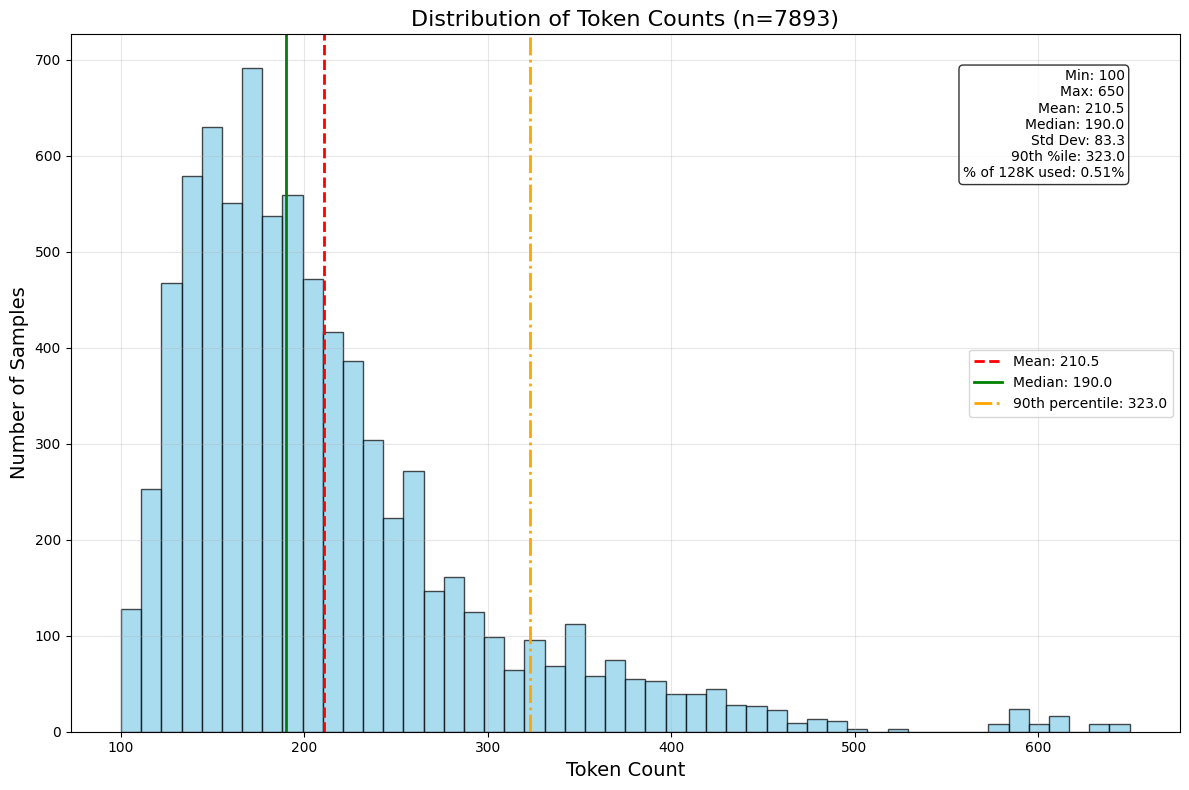


Analyzing validation data tokens...


Analyzing batches:   0%|          | 0/15 [00:00<?, ?it/s]

Analyzing val_batch_0.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing val_batch_1.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing val_batch_10.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing val_batch_11.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing val_batch_12.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing val_batch_13.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing val_batch_14.pkl:   0%|          | 0/13 [00:00<?, ?it/s]

Analyzing val_batch_2.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing val_batch_3.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing val_batch_4.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing val_batch_5.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing val_batch_6.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing val_batch_7.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing val_batch_8.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing val_batch_9.pkl:   0%|          | 0/100 [00:00<?, ?it/s]


Token Usage Analysis:
Total samples analyzed: 1413
Total tokens: 297,272
Average tokens per sample: 210.38
Median tokens per sample: 195.00
90th percentile: 277.00
99th percentile: 429.00
Max tokens in a sample: 903
Min tokens in a sample: 109
Percentage of 128K context window used (max): 0.71%


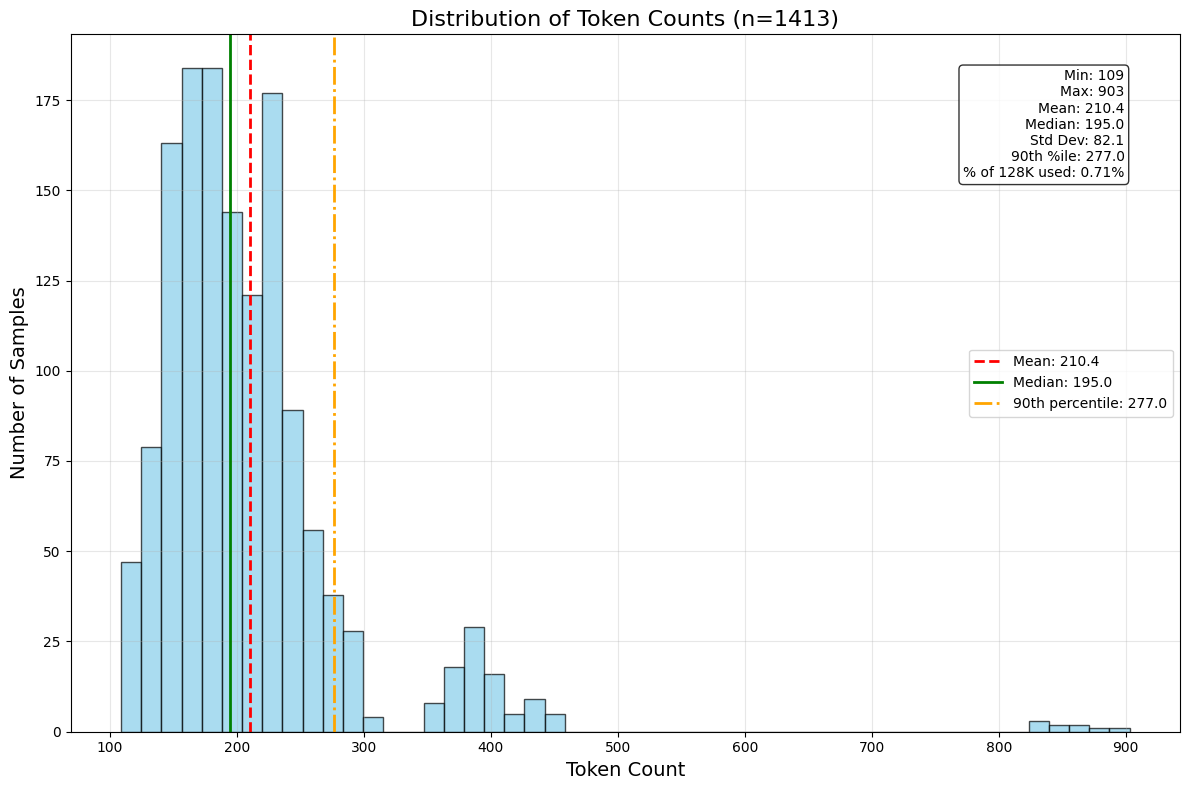


Token analysis complete! Files saved to the outputs directory.


In [148]:
def analyze_dataset_tokens(dataset_dir, processor, num_samples=None):
    """
    Analyze token counts in the dataset without running training or inference
    
    Args:
        dataset_dir: Path to the processed dataset directory
        processor: The processor from the model
        num_samples: Optional limit on number of samples to process
    """
    # Check if directory exists
    if not os.path.exists(dataset_dir):
        print(f"Directory not found: {dataset_dir}")
        return None
    
    token_stats = {
        "samples": [],
        "summary": {}
    }
    
    # Find batch files
    batch_files = sorted([f for f in os.listdir(dataset_dir) if f.startswith("batch_") and f.endswith(".pkl") or
                          f.startswith("val_batch_") and f.endswith(".pkl")])
    
    if not batch_files:
        print(f"No batch files found in {dataset_dir}")
        return None
    
    total_tokens = 0
    max_tokens = 0
    min_tokens = float('inf')
    sample_count = 0
    all_token_counts = []
    
    for batch_file in tqdm(batch_files, desc="Analyzing batches"):
        try:
            with open(os.path.join(dataset_dir, batch_file), 'rb') as f:
                batch_data = pickle.load(f)
            
            for sample in tqdm(batch_data, desc=f"Analyzing {batch_file}", leave=False):
                if not isinstance(sample, dict) or "query_text" not in sample:
                    print(f"Warning: Unexpected sample format in {batch_file}")
                    continue
                    
                # Create the input as it would be during inference
                system_message = """You are a medical image analysis assistant. Your task is to examine the provided clinical images along with clinical context, and select the option(s) that best describe what you see."""
                
                # Format messages similar to during inference
                messages = [
                    {
                        "role": "system",
                        "content": [{"type": "text", "text": system_message}],
                    },
                    {
                        "role": "user",
                        "content": [
                            {"type": "text", "text": sample["query_text"]},
                            # Don't need to actually load the image for token counting
                            {"type": "image", "image": "IMAGE_PLACEHOLDER"},
                        ],
                    },
                ]
                
                # Get formatted text for tokenization
                text = processor.apply_chat_template(messages, add_generation_prompt=False, tokenize=False)
                
                # Count tokens
                tokens = processor.tokenizer.encode(text)
                token_count = len(tokens)
                all_token_counts.append(token_count)
                
                # Update statistics
                total_tokens += token_count
                max_tokens = max(max_tokens, token_count)
                min_tokens = min(min_tokens, token_count)
                
                # Store sample info
                token_stats["samples"].append({
                    "id": sample.get("id", "unknown"),
                    "qid": sample.get("qid", "unknown"),
                    "image": os.path.basename(sample.get("image_path", "unknown")),
                    "token_count": token_count,
                    "text_length": len(sample["query_text"])
                })
                
                sample_count += 1
                if num_samples and sample_count >= num_samples:
                    break
            
            if num_samples and sample_count >= num_samples:
                break
                
        except Exception as e:
            print(f"Error processing batch {batch_file}: {e}")
            continue
    
    if sample_count == 0:
        print("No samples were successfully processed")
        return None
    
    # Calculate summary statistics
    token_stats["summary"] = {
        "total_samples": sample_count,
        "total_tokens": total_tokens,
        "avg_tokens_per_sample": total_tokens / sample_count,
        "max_tokens": max_tokens,
        "min_tokens": min_tokens,
        "median_tokens": np.median(all_token_counts),
        "percentile_90": np.percentile(all_token_counts, 90),
        "percentile_99": np.percentile(all_token_counts, 99)
    }
    
    # Save the analysis
    output_path = os.path.join(OUTPUT_DIR, f"{os.path.basename(dataset_dir)}_token_analysis.json")
    with open(output_path, "w") as f:
        json.dump(token_stats, f, indent=2)
    
    # Display summary
    print("\nToken Usage Analysis:")
    print(f"Total samples analyzed: {sample_count}")
    print(f"Total tokens: {total_tokens:,}")
    print(f"Average tokens per sample: {total_tokens/sample_count:.2f}")
    print(f"Median tokens per sample: {np.median(all_token_counts):.2f}")
    print(f"90th percentile: {np.percentile(all_token_counts, 90):.2f}")
    print(f"99th percentile: {np.percentile(all_token_counts, 99):.2f}")
    print(f"Max tokens in a sample: {max_tokens}")
    print(f"Min tokens in a sample: {min_tokens}")
    print(f"Percentage of 128K context window used (max): {(max_tokens/128000)*100:.2f}%")
    
    # Create better histogram
    plt.figure(figsize=(12, 8))
    
    # Use bins based on data range
    bin_count = min(50, len(set(all_token_counts)))
    
    # Plot histogram with actual counts
    n, bins, patches = plt.hist(all_token_counts, bins=bin_count, alpha=0.7, color='skyblue', edgecolor='black')
    
    # Add mean line
    plt.axvline(x=np.mean(all_token_counts), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(all_token_counts):.1f}')
    
    # Add median line
    plt.axvline(x=np.median(all_token_counts), color='green', linestyle='-', linewidth=2, label=f'Median: {np.median(all_token_counts):.1f}')
    
    # Add 90th percentile line
    plt.axvline(x=np.percentile(all_token_counts, 90), color='orange', linestyle='-.', linewidth=2, label=f'90th percentile: {np.percentile(all_token_counts, 90):.1f}')
    
    plt.title(f"Distribution of Token Counts (n={sample_count})", fontsize=16)
    plt.xlabel("Token Count", fontsize=14)
    plt.ylabel("Number of Samples", fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add text with stats
    stats_text = (
        f"Min: {min_tokens}\n"
        f"Max: {max_tokens}\n"
        f"Mean: {np.mean(all_token_counts):.1f}\n"
        f"Median: {np.median(all_token_counts):.1f}\n"
        f"Std Dev: {np.std(all_token_counts):.1f}\n"
        f"90th %ile: {np.percentile(all_token_counts, 90):.1f}\n"
        f"% of 128K used: {(max_tokens/128000)*100:.2f}%"
    )
    
    # Position text in the upper right
    plt.text(0.95, 0.95, stats_text, 
             transform=plt.gca().transAxes, 
             verticalalignment='top', 
             horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    
    # Save the figure
    plt_path = os.path.join(OUTPUT_DIR, f"{os.path.basename(dataset_dir)}_token_distribution.png")
    plt.savefig(plt_path, dpi=300)
    plt.show()
    
    return token_stats

# Now run for both datasets - make sure the paths are correct
try:
    print("Analyzing training data tokens...")
    train_token_stats = analyze_dataset_tokens("outputs/processed_data", processor)
    
    print("\nAnalyzing validation data tokens...")
    val_token_stats = analyze_dataset_tokens("outputs/processed_val_data", processor)
    
    print("\nToken analysis complete! Files saved to the outputs directory.")
except Exception as e:
    print(f"Error running token analysis: {e}")
    import traceback
    traceback.print_exc()

In [150]:
def check_for_other_please_specify(df, column_name='valid_answers'):
    """
    Check if "other (please specify)" appears as a ground truth answer
    
    Args:
        df: DataFrame to check (train or validation)
        column_name: Column containing the answers (default: 'valid_answers')
    
    Returns:
        Dictionary with statistics about occurrences
    """
    # Convert string representations to lists if needed
    if df[column_name].dtype == 'object':
        import ast
        
        def safe_eval(x):
            try:
                if isinstance(x, list):
                    return x
                if isinstance(x, str) and x.startswith('[') and x.endswith(']'):
                    return ast.literal_eval(x)
                return [x]  # Return single item as list
            except:
                return [str(x)]  # Return as single-item list if eval fails
        
        # Apply the conversion
        valid_answers_lists = df[column_name].apply(safe_eval)
    else:
        valid_answers_lists = df[column_name]
    
    # Check for matches
    matches = []
    for idx, answers in enumerate(valid_answers_lists):
        for answer in answers:
            if isinstance(answer, str) and "other (please specify)" in answer.lower():
                matches.append({
                    "index": idx,
                    "encounter_id": df.iloc[idx].get('encounter_id', 'unknown'),
                    "base_qid": df.iloc[idx].get('base_qid', 'unknown'),
                    "answer": answer,
                    "all_answers": answers
                })
    
    # Summarize findings
    results = {
        "total_rows": len(df),
        "match_count": len(matches),
        "percentage": (len(matches) / len(df)) * 100 if len(df) > 0 else 0,
        "matches": matches
    }
    
    # Print summary
    print(f"Results for {column_name} in dataset with {len(df)} rows:")
    print(f"Found {len(matches)} occurrences of 'other (please specify)' ({results['percentage']:.2f}%)")
    
    if matches:
        print("\nSample matches:")
        for i, match in enumerate(matches[:5]):  # Show up to 5 examples
            print(f"{i+1}. Index {match['index']}, Encounter: {match['encounter_id']}, QID: {match['base_qid']}")
            print(f"   Answer: {match['answer']}")
            print(f"   All answers: {match['all_answers']}")
    
    return results

# Check training data
print("CHECKING TRAINING DATA:")
train_results = check_for_other_please_specify(train_df)

# Check validation data
print("\nCHECKING VALIDATION DATA:")
val_results = check_for_other_please_specify(val_df)

# Check specifically for CQID011 (where "other (please specify)" is likely)
print("\nCHECKING CQID011 IN TRAINING DATA:")
train_cqid011 = train_df[train_df['base_qid'] == 'CQID011']
train_cqid011_results = check_for_other_please_specify(train_cqid011)

print("\nCHECKING CQID011 IN VALIDATION DATA:")
val_cqid011 = val_df[val_df['base_qid'] == 'CQID011']
val_cqid011_results = check_for_other_please_specify(val_cqid011)

CHECKING TRAINING DATA:
Results for valid_answers in dataset with 7893 rows:
Found 95 occurrences of 'other (please specify)' (1.20%)

Sample matches:
1. Index 478, Encounter: ENC00019, QID: CQID011
   Answer: other (please specify)
   All answers: ['other (please specify)']
2. Index 1012, Encounter: ENC00045, QID: CQID011
   Answer: other (please specify)
   All answers: ['head', 'other (please specify)', 'chest/abdomen']
3. Index 1013, Encounter: ENC00045, QID: CQID011
   Answer: other (please specify)
   All answers: ['head', 'other (please specify)', 'chest/abdomen']
4. Index 1014, Encounter: ENC00045, QID: CQID011
   Answer: other (please specify)
   All answers: ['head', 'other (please specify)', 'chest/abdomen']
5. Index 1015, Encounter: ENC00045, QID: CQID011
   Answer: other (please specify)
   All answers: ['head', 'other (please specify)', 'chest/abdomen']

CHECKING VALIDATION DATA:
Results for valid_answers in dataset with 1413 rows:
Found 23 occurrences of 'other (please s

In [153]:
print("\nCHECKING CQID013 IN VALIDATION DATA:")
val_cqid013 = val_df[val_df['base_qid'] == 'CQID013']
val_cqid013_results = check_for_other_please_specify(val_cqid013)


CHECKING CQID013 IN VALIDATION DATA:
Results for valid_answers in dataset with 0 rows:
Found 0 occurrences of 'other (please specify)' (0.00%)
